In [1]:
# Civil War Prediction ML Model using Logistic Regression
# Data Sources: UCDP/PRIO Conflict Data, Polity5, Economic Indicators

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve, precision_recall_curve,
                              accuracy_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# ========================
# 1. LOAD DATASETS
# ========================

print("Loading datasets...")

# Load UCDP/PRIO Conflict Data
conflict_data = pd.read_csv('datasets/UcdpPrioConflict_v25_1.csv')
print(f"Conflict data shape: {conflict_data.shape}")
print("\nConflict data columns:")
print(conflict_data.columns.tolist())

# Load Polity5 data
polity_data = pd.read_excel('datasets/p5v2018.xls')
print(f"\nPolity5 data shape: {polity_data.shape}")
print("\nPolity5 columns:")
print(polity_data.columns.tolist())

# Display sample data
print("\n" + "="*50)
print("SAMPLE DATA")
print("="*50)
print("\nConflict Data Sample:")
print(conflict_data.head())
print("\nPolity5 Data Sample:")
print(polity_data.head())

Loading datasets...
Conflict data shape: (2752, 28)

Conflict data columns:
['conflict_id', 'location', 'side_a', 'side_a_id', 'side_a_2nd', 'side_b', 'side_b_id', 'side_b_2nd', 'incompatibility', 'territory_name', 'year', 'intensity_level', 'cumulative_intensity', 'type_of_conflict', 'start_date', 'start_prec', 'start_date2', 'start_prec2', 'ep_end', 'ep_end_date', 'ep_end_prec', 'gwno_a', 'gwno_a_2nd', 'gwno_b', 'gwno_b_2nd', 'gwno_loc', 'region', 'version']

Polity5 data shape: (17574, 37)

Polity5 columns:
['p5', 'cyear', 'ccode', 'scode', 'country', 'year', 'flag', 'fragment', 'democ', 'autoc', 'polity', 'polity2', 'durable', 'xrreg', 'xrcomp', 'xropen', 'xconst', 'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp', 'prior', 'emonth', 'eday', 'eyear', 'eprec', 'interim', 'bmonth', 'bday', 'byear', 'bprec', 'post', 'change', 'd5', 'sf', 'regtrans']

SAMPLE DATA

Conflict Data Sample:
   conflict_id       location               side_a side_a_id side_a_2nd  \
0        11342          I

Exploring conflict types...

Type of Conflict Distribution:
type_of_conflict
3    2004
4     484
2     147
1     117
Name: count, dtype: int64

Conflict Type Mapping:
1 = Extrasystemic (state vs. non-state outside territory)
2 = Interstate (state vs. state)
3 = Internal/Civil War (state vs. rebel group)
4 = Internationalized internal (civil war with foreign intervention)

Intensity Level Distribution:
intensity_level
1    2066
2     686
Name: count, dtype: int64
1 = Minor conflict (25-999 battle deaths)
2 = War (1000+ battle deaths)


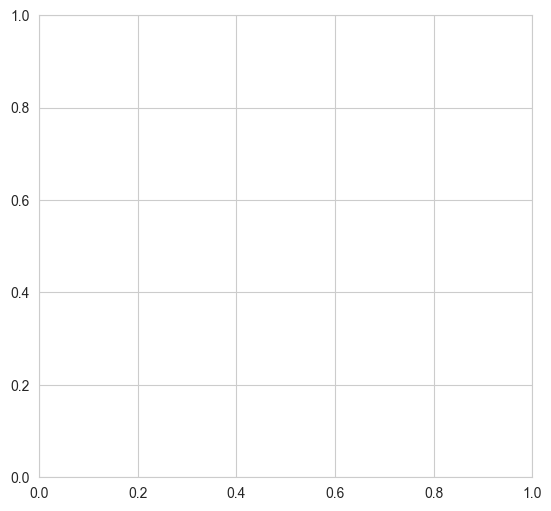

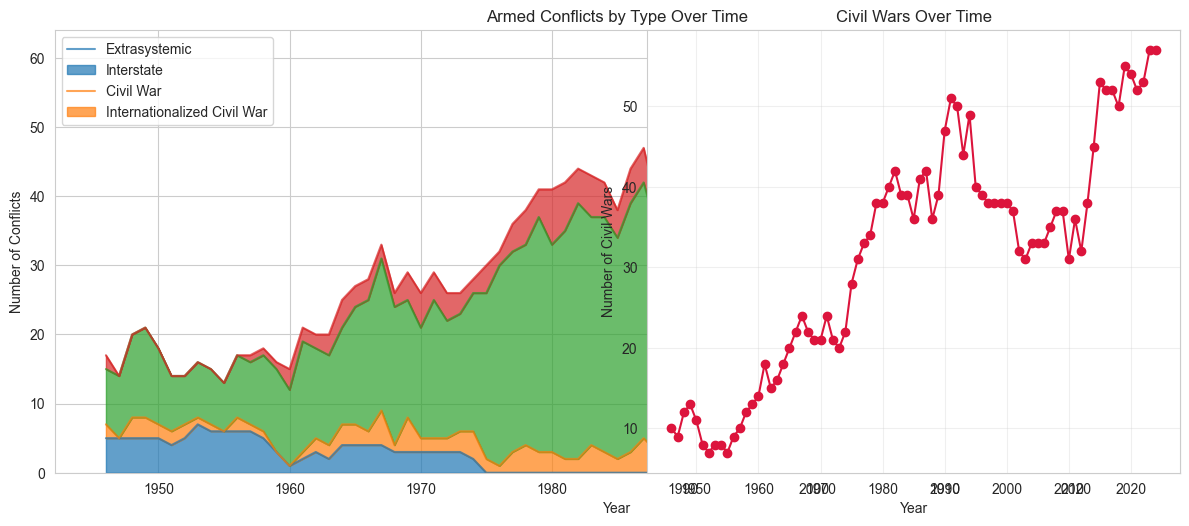


Total civil war records (type 3 & 4): 2488


In [3]:
# ========================
# 2. DATA EXPLORATION
# ========================

print("Exploring conflict types...")
print("\nType of Conflict Distribution:")
print(conflict_data['type_of_conflict'].value_counts())
print("\nConflict Type Mapping:")
print("1 = Extrasystemic (state vs. non-state outside territory)")
print("2 = Interstate (state vs. state)")
print("3 = Internal/Civil War (state vs. rebel group)")
print("4 = Internationalized internal (civil war with foreign intervention)")

# Focus on civil wars (type 3 and 4)
print("\nIntensity Level Distribution:")
print(conflict_data['intensity_level'].value_counts())
print("1 = Minor conflict (25-999 battle deaths)")
print("2 = War (1000+ battle deaths)")

# Visualize conflict types over time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
conflict_by_year = conflict_data.groupby(['year', 'type_of_conflict']).size().unstack(fill_value=0)
conflict_by_year.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Armed Conflicts by Type Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Conflicts')
plt.legend(['Extrasystemic', 'Interstate', 'Civil War', 'Internationalized Civil War'])

plt.subplot(1, 2, 2)
civil_wars = conflict_data[conflict_data['type_of_conflict'].isin([3, 4])]
civil_war_counts = civil_wars.groupby('year').size()
civil_war_counts.plot(kind='line', marker='o', color='crimson')
plt.title('Civil Wars Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Civil Wars')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal civil war records (type 3 & 4): {len(civil_wars)}")

In [4]:
# ========================
# 3. PREPARE TARGET VARIABLE
# ========================

print("Creating target variable: Civil War Onset...")

# Create a dataset of country-years with civil war onset indicator
# Civil war onset = start of a new civil war (type 3 or 4)

# Extract civil war onsets
civil_wars = conflict_data[conflict_data['type_of_conflict'].isin([3, 4])].copy()

# Create onset indicator (first year of conflict for each conflict_id)
civil_wars['is_onset'] = civil_wars.groupby('conflict_id')['year'].transform(lambda x: x == x.min())
civil_war_onsets = civil_wars[civil_wars['is_onset']][['gwno_loc', 'year']].copy()
civil_war_onsets.columns = ['country_code', 'year']
civil_war_onsets['civil_war_onset'] = 1

# Get unique country-years from conflict data
all_conflict_years = conflict_data[['gwno_loc', 'year']].drop_duplicates()
all_conflict_years.columns = ['country_code', 'year']

print(f"\nCivil war onsets detected: {len(civil_war_onsets)}")
print("\nSample onsets:")
print(civil_war_onsets.head(10))

Creating target variable: Civil War Onset...

Civil war onsets detected: 230

Sample onsets:
   country_code  year  civil_war_onset
0           750  2012                1
6           625  2011                1
7           626  2011                1
18          620  2011                1
25          432  2009                1
40          710  2008                1
41          771  2005                1
43          530  1991                1
44          775  1991                1
51          820  2013                1


In [118]:
# ===================================================================
# LOAD AND INTEGRATE ECONOMIC INDICATORS (GemDataEXTR) - FULLY FIXED
# ===================================================================

print("="*70)
print("LOADING ECONOMIC INDICATORS FROM GemDataEXTR")
print("="*70)

import os

def load_and_process_gem_data_robust(filename, indicator_name):
    """
    Load and reshape GEM economic indicator - MOST ROBUST VERSION
    """
    try:
        filepath = f'datasets/GemDataEXTR/{filename}'
        
        # Read Excel file
        df_raw = pd.read_excel(filepath, sheet_name=0, header=None)
        
        # Show structure for debugging (only first file)
        if indicator_name == 'gdp_constant':
            print(f"\n🔍 DEBUG - Raw structure:")
            print(f"   Shape: {df_raw.shape}")
            print(f"   First 5x5 block:")
            print(df_raw.iloc[:5, :5])
            print()
        
        # STRATEGY: Try to detect if transposed or standard format
        # Check first cell value
        first_cell = str(df_raw.iloc[0, 0]).strip().lower() if pd.notna(df_raw.iloc[0, 0]) else ''
        
        # Check if first row contains year-like values
        first_row_values = df_raw.iloc[0, 1:6].astype(str).tolist()
        has_years_in_first_row = any(str(val).replace('.0', '').isdigit() 
                                      and len(str(val).replace('.0', '')) == 4 
                                      for val in first_row_values if pd.notna(val))
        
        # CASE 1: Standard format (countries in rows, years in columns)
        if 'country' in first_cell or 'economy' in first_cell or has_years_in_first_row:
            print(f"  → Standard format detected for {indicator_name}")
            
            # Use first row as header
            df = pd.read_excel(filepath, sheet_name=0, header=0)
            
            # Find country column
            country_col = None
            for col in df.columns:
                if any(term in str(col).lower() for term in ['country', 'economy', 'nation']):
                    country_col = col
                    break
            
            if country_col is None:
                country_col = df.columns[0]  # Assume first column is country
            
            # Find year columns (numeric, 4 digits)
            year_cols = []
            for col in df.columns:
                if col == country_col:
                    continue
                col_str = str(col).replace('.0', '').replace('Q', '').replace('-', '')
                if col_str.isdigit() and len(col_str) >= 4:
                    year_cols.append(col)
            
            if not year_cols:
                print(f"  ✗ {indicator_name}: No year columns found")
                return None
            
            # Melt to long format
            df_long = df.melt(
                id_vars=[country_col],
                value_vars=year_cols,
                var_name='year',
                value_name=indicator_name
            )
            
            df_long = df_long.rename(columns={country_col: 'country_name'})
        
        # CASE 2: Transposed format (years in rows, countries in columns)
        else:
            print(f"  → Transposed format detected for {indicator_name}")
            
            # First row has country names, first column has years
            # Read with first row as header
            df = pd.read_excel(filepath, sheet_name=0, header=0)
            
            # First column should be years
            year_col = df.columns[0]
            
            # All other columns are countries
            country_cols = [col for col in df.columns if col != year_col]
            
            if not country_cols:
                print(f"  ✗ {indicator_name}: No country columns found")
                return None
            
            # Melt to long format
            df_long = df.melt(
                id_vars=[year_col],
                value_vars=country_cols,
                var_name='country_name',
                value_name=indicator_name
            )
            
            df_long = df_long.rename(columns={year_col: 'year'})
        
        # CLEAN THE DATA
        # Extract year (handle formats like '2010', '2010Q1', '2010.0')
        df_long['year'] = df_long['year'].astype(str)
        df_long['year'] = df_long['year'].str.extract(r'(\d{4})')[0]
        df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
        
        # Clean country names
        df_long['country_name'] = df_long['country_name'].astype(str).str.strip()
        df_long['country_name'] = df_long['country_name'].replace(['nan', 'None', ''], np.nan)
        
        # Convert indicator values to numeric
        df_long[indicator_name] = pd.to_numeric(df_long[indicator_name], errors='coerce')
        
        # Remove invalid rows
        df_long = df_long.dropna(subset=['country_name', 'year', indicator_name])
        
        # Remove duplicates
        df_long = df_long.drop_duplicates(subset=['country_name', 'year'])
        
        if len(df_long) > 0:
            n_countries = df_long['country_name'].nunique()
            year_range = f"{df_long['year'].min():.0f}-{df_long['year'].max():.0f}"
            print(f"  ✓ {indicator_name}: {len(df_long):,} obs, {n_countries} countries, years {year_range}")
            return df_long
        else:
            print(f"  ✗ {indicator_name}: No valid data after cleaning")
            return None
            
    except Exception as e:
        print(f"  ✗ {indicator_name}: Error - {str(e)[:120]}")
        import traceback
        if indicator_name == 'gdp_constant':  # Show full error for first file
            print(f"     Full traceback: {traceback.format_exc()[:300]}")
        return None

# Define economic indicators to load
economic_indicators = {
    'GDP at market prices, constant 2010 US$, millions, seas. adj..xlsx': 'gdp_constant',
    'Unemployment Rate, seas. adj..xlsx': 'unemployment_rate',
    'CPI Price, % y-o-y, nominal, seas. adj..xlsx': 'inflation_rate',
    'Exports Merchandise, Customs, constant 2010 US$, millions, seas. adj..xlsx': 'exports_constant',
    'Imports Merchandise, Customs, constant 2010 US$, millions, seas. adj..xlsx': 'imports_constant',
    'Total Reserves.xlsx': 'total_reserves',
    'Exchange rate, new LCU per USD extended backward, period average.xlsx': 'exchange_rate',
}

print("\n" + "="*70)
print("LOADING ECONOMIC INDICATORS...")
print("-" * 70)

# Check if directory exists
gem_path = 'datasets/GemDataEXTR/'
if not os.path.exists(gem_path):
    print(f"Directory not found: {gem_path}")
    print("   Please check the path!")
    economic_data = None
else:
    print(f"✓ Directory found: {gem_path}")
    print(f"  Files in directory: {len(os.listdir(gem_path))}")
    
    # Load all indicators
    economic_dfs = {}
    for filename, indicator_name in economic_indicators.items():
        full_path = os.path.join(gem_path, filename)
        if os.path.exists(full_path):
            df = load_and_process_gem_data_robust(filename, indicator_name)
            if df is not None:
                economic_dfs[indicator_name] = df
        else:
            print(f"  File not found: {filename}")
    
    print(f"\n{'='*70}")
    print(f"✓ Successfully loaded {len(economic_dfs)}/{len(economic_indicators)} indicators")
    
    # Merge all economic indicators
    if len(economic_dfs) > 0:
        print("\n" + "-"*70)
        print("Merging economic indicators...")
        
        # Start with all unique country-year combinations
        all_data = []
        for indicator_name, df in economic_dfs.items():
            all_data.append(df[['country_name', 'year', indicator_name]])
        
        # Merge iteratively
        economic_data = all_data[0]
        for df in all_data[1:]:
            economic_data = economic_data.merge(
                df,
                on=['country_name', 'year'],
                how='outer'
            )
        
        # Sort by country and year
        economic_data = economic_data.sort_values(['country_name', 'year']).reset_index(drop=True)
        
        print(f"✓ Combined economic data: {economic_data.shape}")
        print(f"  Countries: {economic_data['country_name'].nunique()}")
        print(f"  Time range: {economic_data['year'].min():.0f} - {economic_data['year'].max():.0f}")
        print(f"  Total observations: {len(economic_data):,}")
        
        # Show data quality
        print("\nData Coverage:")
        for col in economic_data.columns:
            if col not in ['country_name', 'year']:
                non_null = economic_data[col].notna().sum()
                coverage = (non_null / len(economic_data)) * 100
                print(f"  • {col:25s}: {non_null:6,} obs ({coverage:5.1f}% coverage)")
        
        # Display sample
        print("\nSample data (first 10 rows):")
        display_cols = ['country_name', 'year'] + [col for col in economic_data.columns 
                                                     if col not in ['country_name', 'year']][:5]
        print(economic_data[display_cols].head(10).to_string())
        
        print("\n" + "="*70)
        print("ECONOMIC DATA LOADED SUCCESSFULLY!")
        print("="*70)
        
    else:
        print("\nNo economic indicators loaded successfully")
        print("Possible issues:")
        print("  1. Excel files may be corrupted")
        print("  2. Unexpected file format/structure")
        print("  3. Missing required dependencies (openpyxl)")
        economic_data = None

LOADING ECONOMIC INDICATORS FROM GemDataEXTR

LOADING ECONOMIC INDICATORS...
----------------------------------------------------------------------
✓ Directory found: datasets/GemDataEXTR/
  Files in directory: 35

🔍 DEBUG - Raw structure:
   Shape: (32, 101)
   First 5x5 block:
        0         1                   2          3          4
0     NaN   Albania  Advanced Economies  Argentina  Australia
1     NaN       NaN                 NaN        NaN        NaN
2  1996.0  6284.499            32820390   278501.1   750085.9
3  1997.0  5530.081            33918523   301081.5   785437.9
4  1998.0  6014.254            34818181   312567.3   822127.1

  → Transposed format detected for gdp_constant
  ✓ gdp_constant: 2,696 obs, 98 countries, years 1996-2025
  → Transposed format detected for unemployment_rate
  ✓ unemployment_rate: 1,876 obs, 77 countries, years 1996-2025
  → Transposed format detected for inflation_rate
  ✓ inflation_rate: 3,005 obs, 108 countries, years 1996-2025
  → Transpo

In [ ]:
# ===================================================================
# ENGINEER ECONOMIC FEATURES
# ===================================================================

if economic_data is not None:
    print("="*70)
    print("ENGINEERING ECONOMIC FEATURES")
    print("="*70)
    
    # Sort by country and year for time-series features
    economic_data = economic_data.sort_values(['country_name', 'year'])
    
    # -----------------------------
    # 1. GROWTH RATES
    # -----------------------------
    print("\n1. Creating growth rate features...")
    
    if 'gdp_constant' in economic_data.columns:
        economic_data['gdp_growth'] = (
            economic_data.groupby('country_name')['gdp_constant']
            .pct_change() * 100
        )
        print("   ✓ gdp_growth")
    
    if 'exports_constant' in economic_data.columns:
        economic_data['export_growth'] = (
            economic_data.groupby('country_name')['exports_constant']
            .pct_change() * 100
        )
        print("   ✓ export_growth")
    
    if 'imports_constant' in economic_data.columns:
        economic_data['import_growth'] = (
            economic_data.groupby('country_name')['imports_constant']
            .pct_change() * 100
        )
        print("   ✓ import_growth")
    
    # -----------------------------
    # 2. ECONOMIC SHOCKS
    # -----------------------------
    print("\n2. Creating economic shock indicators...")
    
    if 'gdp_growth' in economic_data.columns:
        # Negative growth
        economic_data['recession'] = (economic_data['gdp_growth'] < 0).astype(int)
        
        # Severe recession
        economic_data['severe_recession'] = (economic_data['gdp_growth'] < -2).astype(int)
        
        # Economic crisis
        economic_data['economic_crisis'] = (economic_data['gdp_growth'] < -5).astype(int)
        
        print("   ✓ recession, severe_recession, economic_crisis")
    
    # Inflation crisis
    if 'inflation_rate' in economic_data.columns:
        economic_data['high_inflation'] = (economic_data['inflation_rate'] > 10).astype(int)
        economic_data['hyperinflation'] = (economic_data['inflation_rate'] > 50).astype(int)
        print("   ✓ high_inflation, hyperinflation")
    
    # -----------------------------
    # 3. TRADE FEATURES
    # -----------------------------
    print("\n3. Creating trade features...")
    
    if 'exports_constant' in economic_data.columns and 'imports_constant' in economic_data.columns:
        # Trade balance
        economic_data['trade_balance'] = (
            economic_data['exports_constant'] - economic_data['imports_constant']
        )
        
        # Trade deficit indicator
        economic_data['trade_deficit'] = (economic_data['trade_balance'] < 0).astype(int)
        
        print("   ✓ trade_balance, trade_deficit")
        
        # Trade openness (relative to GDP)
        if 'gdp_constant' in economic_data.columns:
            economic_data['trade_openness'] = (
                (economic_data['exports_constant'] + economic_data['imports_constant']) 
                / economic_data['gdp_constant']
            )
            print("   ✓ trade_openness")
    
    # -----------------------------
    # 4. EXCHANGE RATE FEATURES
    # -----------------------------
    print("\n4. Creating exchange rate features...")
    
    if 'exchange_rate' in economic_data.columns:
        # Currency depreciation
        economic_data['exchange_rate_change'] = (
            economic_data.groupby('country_name')['exchange_rate']
            .pct_change() * 100
        )
        
        # Rapid depreciation (>20% annual)
        economic_data['currency_crisis'] = (
            economic_data['exchange_rate_change'] > 20
        ).astype(int)
        
        print("   ✓ exchange_rate_change, currency_crisis")
    
    # -----------------------------
    # 5. RESERVES ADEQUACY
    # -----------------------------
    print("\n5. Creating reserves features...")
    
    if 'total_reserves' in economic_data.columns and 'imports_constant' in economic_data.columns:
        # Reserves in months of imports (IMF guideline: >3 months)
        economic_data['reserves_months_imports'] = (
            economic_data['total_reserves'] / 
            (economic_data['imports_constant'] / 12)
        )
        
        # Low reserves warning
        economic_data['low_reserves'] = (
            economic_data['reserves_months_imports'] < 3
        ).astype(int)
        
        print("   ✓ reserves_months_imports, low_reserves")
    
    # -----------------------------
    # 6. VOLATILITY FEATURES
    # -----------------------------
    print("\n6. Creating volatility features...")
    
    if 'gdp_growth' in economic_data.columns:
        # GDP growth volatility (rolling 3-year std)
        economic_data['gdp_volatility_3yr'] = (
            economic_data.groupby('country_name')['gdp_growth']
            .transform(lambda x: x.rolling(3, min_periods=1).std())
        )
        print("   ✓ gdp_volatility_3yr")
    
    if 'inflation_rate' in economic_data.columns:
        # Inflation volatility
        economic_data['inflation_volatility_3yr'] = (
            economic_data.groupby('country_name')['inflation_rate']
            .transform(lambda x: x.rolling(3, min_periods=1).std())
        )
        print("   ✓ inflation_volatility_3yr")
    
    # -----------------------------
    # 7. LAGGED ECONOMIC FEATURES
    # -----------------------------
    print("\n7. Creating lagged features...")
    
    lag_features = ['gdp_growth', 'unemployment_rate', 'inflation_rate', 
                    'export_growth', 'trade_balance']
    
    for feature in lag_features:
        if feature in economic_data.columns:
            economic_data[f'{feature}_lag1'] = (
                economic_data.groupby('country_name')[feature].shift(1)
            )
            print(f"   ✓ {feature}_lag1")
    
    # -----------------------------
    # SUMMARY
    # -----------------------------
    print("\n" + "="*70)
    print("ECONOMIC FEATURES SUMMARY")
    print("="*70)
    print(f"Total features: {economic_data.shape[1] - 2}")  # Exclude country_name and year
    print(f"Observations: {economic_data.shape[0]:,}")
    print(f"Time range: {economic_data['year'].min():.0f}-{economic_data['year'].max():.0f}")
    
    print("\nFeature categories:")
    print(f"  • Raw indicators: {len(economic_indicators)}")
    print(f"  • Growth rates: 3")
    print(f"  • Shock indicators: 6")
    print(f"  • Trade features: 4")
    print(f"  • Exchange rate: 2")
    print(f"  • Reserves: 2")
    print(f"  • Volatility: 2")
    print(f"  • Lagged features: {len([c for c in economic_data.columns if 'lag' in c])}")
    
    print("\nSample with new features:")
    display_cols = ['country_name', 'year', 'gdp_growth', 'recession', 
                    'unemployment_rate', 'inflation_rate', 'trade_deficit']
    display_cols = [c for c in display_cols if c in economic_data.columns]
    print(economic_data[display_cols].head(10))
    
else:
    print("Skipping economic feature engineering - no data loaded")

ENGINEERING ECONOMIC FEATURES

1. Creating growth rate features...
   ✓ gdp_growth
   ✓ export_growth
   ✓ import_growth

2. Creating economic shock indicators...
   ✓ recession, severe_recession, economic_crisis
   ✓ high_inflation, hyperinflation

3. Creating trade features...
   ✓ trade_balance, trade_deficit
   ✓ trade_openness

4. Creating exchange rate features...
   ✓ exchange_rate_change, currency_crisis

5. Creating reserves features...
   ✓ reserves_months_imports, low_reserves

6. Creating volatility features...
   ✓ gdp_volatility_3yr
   ✓ inflation_volatility_3yr

7. Creating lagged features...
   ✓ gdp_growth_lag1
   ✓ unemployment_rate_lag1
   ✓ inflation_rate_lag1
   ✓ export_growth_lag1
   ✓ trade_balance_lag1

ECONOMIC FEATURES SUMMARY
Total features: 29
Observations: 5,915
Time range: 1996-2025

Feature categories:
  • Raw indicators: 7
  • Growth rates: 3
  • Shock indicators: 6
  • Trade features: 4
  • Exchange rate: 2
  • Reserves: 2
  • Volatility: 2
  • Lagged 

In [119]:
# ===================================================================
# MERGE ECONOMIC DATA WITH CONFLICT + POLITY DATA
# ===================================================================

if economic_data is not None:
    print("="*70)
    print("MERGING ECONOMIC DATA WITH POLITY5 + CONFLICT DATA")
    print("="*70)
    
    # First, we need a country name mapping from Polity5
    # Polity has both country codes and names
    
    print("\nStep 1: Create country name mapping...")
    
    # Get unique country mappings from Polity5
    country_mapping = polity_data[['ccode', 'country']].drop_duplicates()
    print(f"  Polity5 has {len(country_mapping)} unique countries")
    
    # Add country names to our merged polity_clean data
    if 'country' not in polity_clean.columns:
        polity_clean = polity_clean.merge(
            country_mapping,
            on='ccode',
            how='left'
        )
    
    print(f"  Polity_clean now has country names: {polity_clean['country'].notna().sum()} observations")
    
    # Step 2: Merge economic data
    print("\nStep 2: Merging economic indicators...")
    
    # Merge on country name and year
    polity_with_econ = polity_clean.merge(
        economic_data,
        left_on=['country', 'year'],
        right_on=['country_name', 'year'],
        how='left'
    )
    
    # Drop duplicate country_name column
    if 'country_name' in polity_with_econ.columns:
        polity_with_econ = polity_with_econ.drop(columns=['country_name'])
    
    print(f"\n✓ Merge complete!")
    print(f"  Original polity_clean shape: {polity_clean.shape}")
    print(f"  With economic data shape: {polity_with_econ.shape}")
    print(f"  New columns added: {polity_with_econ.shape[1] - polity_clean.shape[1]}")
    
    # Check merge quality
    economic_cols = [col for col in economic_data.columns if col not in ['country_name', 'year']]
    
    print("\nMerge quality check:")
    for col in economic_cols[:5]:  # Check first 5 economic columns
        if col in polity_with_econ.columns:
            non_null_pct = (polity_with_econ[col].notna().sum() / len(polity_with_econ)) * 100
            print(f"  {col}: {non_null_pct:.1f}% coverage")
    
    # Update polity_clean with economic data
    polity_clean = polity_with_econ.copy()
    
    print("\n" + "="*70)
    print("ECONOMIC DATA INTEGRATED!")
    print("="*70)
    print(f"Updated dataset now has {polity_clean.shape[1]} total columns")
    print(f"Including {len(economic_cols)} economic features")
    
else:
    print("Skipping economic data merge - no economic data available")

MERGING ECONOMIC DATA WITH POLITY5 + CONFLICT DATA

Step 1: Create country name mapping...
  Polity5 has 198 unique countries
  Polity_clean now has country names: 17589 observations

Step 2: Merging economic indicators...

✓ Merge complete!
  Original polity_clean shape: (17589, 68)
  With economic data shape: (17589, 75)
  New columns added: 7

Merge quality check:

ECONOMIC DATA INTEGRATED!
Updated dataset now has 75 total columns
Including 7 economic features


In [5]:
# ========================
# 4. MERGE WITH POLITY5 DATA
# ========================

print("Merging with Polity5 political regime data...")

# Check Polity5 column names
print("\nPolity5 key columns:")
polity_cols = [col for col in polity_data.columns if col.lower() in 
               ['country', 'year', 'cyear', 'ccode', 'scode', 'polity', 'polity2', 
                'democ', 'autoc', 'durable', 'xrreg', 'xrcomp', 'xropen', 'xconst', 
                'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp']]
print(polity_cols)

# Prepare Polity5 data
polity_clean = polity_data.copy()

# Check data types
print(f"\nPolity ccode type: {polity_clean['ccode'].dtype}")
print(f"Civil war onsets country_code type: {civil_war_onsets['country_code'].dtype}")

# Convert both to the same type (int) for merging
# First, handle any non-numeric values in civil_war_onsets
civil_war_onsets['country_code'] = pd.to_numeric(civil_war_onsets['country_code'], errors='coerce')
civil_war_onsets = civil_war_onsets.dropna(subset=['country_code'])  # Drop any rows that couldn't be converted
civil_war_onsets['country_code'] = civil_war_onsets['country_code'].astype(int)

print(f"\nAfter conversion - country_code type: {civil_war_onsets['country_code'].dtype}")
print(f"Civil war onsets after cleaning: {len(civil_war_onsets)}")

# Now merge with matching data types
polity_clean = polity_clean.merge(civil_war_onsets, 
                                   left_on=['ccode', 'year'], 
                                   right_on=['country_code', 'year'], 
                                   how='left')

# Fill NaN in civil_war_onset with 0 (no onset)
polity_clean['civil_war_onset'] = polity_clean['civil_war_onset'].fillna(0).astype(int)

print(f"\nMerged dataset shape: {polity_clean.shape}")
print(f"Civil war onsets in dataset: {polity_clean['civil_war_onset'].sum()}")
print(f"Class balance:")
print(polity_clean['civil_war_onset'].value_counts(normalize=True))

Merging with Polity5 political regime data...

Polity5 key columns:
['cyear', 'ccode', 'scode', 'country', 'year', 'democ', 'autoc', 'polity', 'polity2', 'durable', 'xrreg', 'xrcomp', 'xropen', 'xconst', 'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp']

Polity ccode type: int64
Civil war onsets country_code type: object

After conversion - country_code type: int64
Civil war onsets after cleaning: 230

Merged dataset shape: (17589, 39)
Civil war onsets in dataset: 208
Class balance:
civil_war_onset
0    0.988174
1    0.011826
Name: proportion, dtype: float64


In [120]:
# ===================================================================
# FEATURE ENGINEERING (WITH ECONOMIC FEATURES)
# ===================================================================

print("="*70)
print("FEATURE ENGINEERING: POLITICAL + ECONOMIC")
print("="*70)

# Core political features
political_features = ['polity2', 'democ', 'autoc', 'durable', 'xconst', 
                      'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']

# Economic features (add those that were successfully loaded)
economic_features = [col for col in polity_clean.columns if col in [
    'gdp_growth', 'gdp_constant', 'unemployment_rate', 'inflation_rate',
    'exports_constant', 'imports_constant', 'export_growth', 'import_growth',
    'trade_balance', 'trade_openness', 'trade_deficit',
    'exchange_rate', 'exchange_rate_change', 'currency_crisis',
    'total_reserves', 'reserves_months_imports', 'low_reserves',
    'recession', 'severe_recession', 'economic_crisis',
    'high_inflation', 'hyperinflation',
    'gdp_volatility_3yr', 'inflation_volatility_3yr',
    'gdp_growth_lag1', 'unemployment_rate_lag1', 'inflation_rate_lag1'
]]

print(f"\nPolitical features: {len(political_features)}")
print(f"Economic features: {len(economic_features)}")

# Combine all features
all_features = political_features + economic_features
available_features = [col for col in all_features if col in polity_clean.columns]

print(f"Total available features: {len(available_features)}")

# Create modeling dataset
model_data = polity_clean[['year', 'ccode', 'civil_war_onset'] + available_features].copy()

# Handle special codes in Polity data
for col in political_features:
    if col in model_data.columns:
        model_data[col] = model_data[col].replace([-66, -77, -88, -99], np.nan)

# Sort by country and year
model_data = model_data.sort_values(['ccode', 'year'])

# --- Create Political Regime Features ---
if 'polity2' in available_features:
    model_data['anocracy'] = ((model_data['polity2'] >= -5) & 
                               (model_data['polity2'] <= 5)).astype(int)
    model_data['full_autocracy'] = (model_data['polity2'] <= -6).astype(int)
    print("✓ Created regime type indicators")

if 'durable' in available_features:
    model_data['new_regime'] = (model_data['durable'] <= 2).astype(int)
    print("✓ Created regime stability indicators")

# --- Create Lagged Political Features ---
for col in political_features:
    if col in model_data.columns:
        model_data[f'{col}_lag1'] = model_data.groupby('ccode')[col].shift(1)

print("✓ Created lagged political features")

# --- Create Political Change Features ---
if 'polity2' in available_features:
    model_data['polity_change'] = model_data.groupby('ccode')['polity2'].diff()
    model_data['regime_change'] = (abs(model_data['polity_change']) >= 3).astype(int)
    print("✓ Created regime change indicators")

# --- Create Interaction Features (Political × Economic) ---
print("\nCreating interaction features...")

if 'anocracy' in model_data.columns and 'recession' in model_data.columns:
    model_data['anocracy_x_recession'] = (
        model_data['anocracy'] * model_data['recession']
    )
    print("✓ anocracy × recession")

if 'new_regime' in model_data.columns and 'economic_crisis' in model_data.columns:
    model_data['new_regime_x_crisis'] = (
        model_data['new_regime'] * model_data['economic_crisis']
    )
    print("✓ new_regime × economic_crisis")

if 'full_autocracy' in model_data.columns and 'high_inflation' in model_data.columns:
    model_data['autocracy_x_inflation'] = (
        model_data['full_autocracy'] * model_data['high_inflation']
    )
    print("✓ autocracy × high_inflation")

print("\n" + "="*70)
print("FEATURE SUMMARY")
print("="*70)
print(f"Total features created: {model_data.shape[1] - 3}")  # Exclude year, ccode, target
print(f"  Political features: ~{len([c for c in model_data.columns if any(p in c for p in political_features)])}")
print(f"  Economic features: ~{len([c for c in model_data.columns if any(e in c for e in economic_features)])}")
print(f"  Interaction features: {len([c for c in model_data.columns if '_x_' in c])}")

print("\nAll features:")
feature_list = [c for c in model_data.columns if c not in ['year', 'ccode', 'civil_war_onset']]
for i, feat in enumerate(feature_list, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nFeature engineering complete with {len(feature_list)} features!")

FEATURE ENGINEERING: POLITICAL + ECONOMIC

Political features: 10
Economic features: 20
Total available features: 30
✓ Created regime type indicators
✓ Created regime stability indicators
✓ Created lagged political features
✓ Created regime change indicators

Creating interaction features...
✓ anocracy × recession
✓ new_regime × economic_crisis
✓ autocracy × high_inflation

FEATURE SUMMARY
Total features created: 48
  Political features: ~22
  Economic features: ~21
  Interaction features: 3

All features:
   1. polity2
   2. democ
   3. autoc
   4. durable
   5. xconst
   6. xrcomp
   7. xropen
   8. parcomp
   9. exrec
  10. exconst
  11. gdp_growth
  12. export_growth
  13. import_growth
  14. recession
  15. severe_recession
  16. economic_crisis
  17. high_inflation
  18. hyperinflation
  19. trade_balance
  20. trade_deficit
  21. trade_openness
  22. exchange_rate_change
  23. currency_crisis
  24. reserves_months_imports
  25. low_reserves
  26. gdp_volatility_3yr
  27. inflati

In [ ]:
# ===================================================================
# PREPARE DATA FOR MODELING (WITH ECONOMIC FEATURES)
# ===================================================================

print("="*70)
print("DATA PREPARATION FOR MODELING")
print("="*70)

print("\nStep 1: Selecting features...")

# Separate features and target
feature_cols = [col for col in model_data.columns 
                if col not in ['year', 'ccode', 'civil_war_onset', 'country', 'country_name']]

X = model_data[feature_cols].copy()
y = model_data['civil_war_onset'].copy()

print(f"✓ Features selected: {len(feature_cols)}")
print(f"  Political features: {len([c for c in feature_cols if any(p in c for p in ['polity', 'democ', 'autoc', 'xconst', 'xrcomp', 'parcomp', 'exrec', 'durable'])])}")
print(f"  Economic features: {len([c for c in feature_cols if any(e in c for e in ['gdp', 'unemployment', 'inflation', 'trade', 'export', 'import', 'exchange', 'reserves', 'recession', 'crisis'])])}")

print(f"\nStep 2: Handling missing values...")
print(f"Missing values before:")
print(f"  Total cells: {X.shape[0] * X.shape[1]:,}")
print(f"  Missing cells: {X.isna().sum().sum():,}")
print(f"  Missing percentage: {(X.isna().sum().sum() / (X.shape[0] * X.shape[1])) * 100:.2f}%")

# Strategy: Drop rows with too many missing values, then drop columns with remaining missing
# Drop rows missing >50% of features
threshold = len(feature_cols) * 0.5
model_data_clean = model_data[X.notna().sum(axis=1) >= threshold].copy()
print(f"  Dropped {len(model_data) - len(model_data_clean):,} rows with >{50}% missing")

# Update X and y
X = model_data_clean[feature_cols].copy()
y = model_data_clean['civil_war_onset'].copy()

# Drop features with >30% missing
features_to_keep = X.columns[X.notna().sum() > len(X) * 0.7]
X = X[features_to_keep].copy()

print(f"  Dropped {len(feature_cols) - len(features_to_keep)} features with >30% missing")
print(f"  Remaining features: {len(features_to_keep)}")

# Fill remaining missing values with median (more robust than mean for economic data)
for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

print(f"\nMissing values after:")
print(f"  Missing cells: {X.isna().sum().sum()}")

# Final check
assert X.isna().sum().sum() == 0, "Still have missing values!"
assert len(X) == len(y), "X and y length mismatch!"

print(f"\n✓ Data cleaned successfully")
print(f"  Final shape: X={X.shape}, y={y.shape}")
print(f"  Civil war onsets: {y.sum()} ({y.mean()*100:.2f}%)")
print(f"  No onset: {(y==0).sum()} ({(y==0).mean()*100:.2f}%)")
print(f"  Imbalance ratio: {(y==0).sum() / y.sum():.1f}:1")

# Store feature names for later use
feature_names = X.columns.tolist()

print("\n" + "="*70)
print("FINAL FEATURE SET")
print("="*70)
print(f"Total features: {len(feature_names)}")
print("\nFeatures by category:")

# Political
political = [f for f in feature_names if any(p in f for p in ['polity', 'democ', 'autoc', 'xconst', 'xrcomp', 'parcomp', 'exrec', 'durable', 'anocracy', 'regime'])]
print(f"\nPolitical ({len(political)}):")
for f in political[:10]:
    print(f"  • {f}")
if len(political) > 10:
    print(f"  ... and {len(political)-10} more")

# Economic
economic = [f for f in feature_names if any(e in f for e in ['gdp', 'unemployment', 'inflation', 'trade', 'export', 'import', 'exchange', 'reserves', 'recession', 'crisis'])]
print(f"\n💰 Economic ({len(economic)}):")
for f in economic[:10]:
    print(f"  • {f}")
if len(economic) > 10:
    print(f"  ... and {len(economic)-10} more")

# Interaction
interaction = [f for f in feature_names if '_x_' in f]
if interaction:
    print(f"\n🔗 Interaction ({len(interaction)}):")
    for f in interaction:
        print(f"  • {f}")

print("\nData preparation complete!")

DATA PREPARATION FOR MODELING

Step 1: Selecting features...
✓ Features selected: 55
  Political features: 21
  Economic features: 30

Step 2: Handling missing values...
Missing values before:
  Total cells: 967,395
  Missing cells: 484,810
  Missing percentage: 50.11%
  Dropped 14,521 rows with >50% missing
  Dropped 16 features with >30% missing
  Remaining features: 39

Missing values after:
  Missing cells: 0

✓ Data cleaned successfully
  Final shape: X=(3068, 39), y=(3068,)
  Civil war onsets: 44 (1.43%)
  No onset: 3024 (98.57%)
  Imbalance ratio: 68.7:1

FINAL FEATURE SET
Total features: 39

Features by category:

📊 Political (26):
  • polity2
  • democ
  • autoc
  • durable
  • xconst
  • xrcomp
  • parcomp
  • exrec
  • exconst
  • anocracy
  ... and 16 more

💰 Economic (14):
  • total_reserves
  • exchange_rate
  • recession
  • severe_recession
  • economic_crisis
  • high_inflation
  • hyperinflation
  • trade_deficit
  • exchange_rate_change
  • currency_crisis
  ... and 

In [121]:
# ===================================================================
# TRAIN-TEST SPLIT (STRATIFIED)
# ===================================================================

print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

# Choose split ratio
TEST_SIZE = 0.2  

print(f"\nSplit configuration:")
print(f"  Train size: {(1-TEST_SIZE)*100:.0f}%")
print(f"  Test size: {TEST_SIZE*100:.0f}%")
print(f"  Stratification: YES (maintains class balance)")

# Stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y  
)

print(f"\n" + "="*70)
print("SPLIT RESULTS")
print("="*70)

print(f"\nTRAINING SET:")
print(f"  Total observations: {len(X_train):,}")
print(f"  Civil war onsets: {y_train.sum()}")
print(f"  No onset: {(y_train==0).sum():,}")
print(f"  Onset rate: {y_train.mean()*100:.2f}%")

print(f"\nTEST SET:")
print(f"  Total observations: {len(X_test):,}")
print(f"  Civil war onsets: {y_test.sum()}")
print(f"  No onset: {(y_test==0).sum():,}")
print(f"  Onset rate: {y_test.mean()*100:.2f}%")

print(f"\n✓ Class balance maintained:")
print(f"  Train onset rate: {y_train.mean()*100:.2f}%")
print(f"  Test onset rate: {y_test.mean()*100:.2f}%")
print(f"  Difference: {abs(y_train.mean() - y_test.mean())*100:.3f}% (should be small)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features standardized (z-score normalization)")
print(f"  Mean ≈ 0, Std ≈ 1")

print("\n" + "="*70)
print(" DATA READY FOR MODELING!")
print("="*70)

TRAIN-TEST SPLIT

Split configuration:
  Train size: 80%
  Test size: 20%
  Stratification: YES (maintains class balance)

SPLIT RESULTS

TRAINING SET:
  Total observations: 2,454
  Civil war onsets: 35
  No onset: 2,419
  Onset rate: 1.43%

TEST SET:
  Total observations: 614
  Civil war onsets: 9
  No onset: 605
  Onset rate: 1.47%

✓ Class balance maintained:
  Train onset rate: 1.43%
  Test onset rate: 1.47%
  Difference: 0.040% (should be small)

✓ Features standardized (z-score normalization)
  Mean ≈ 0, Std ≈ 1

 DATA READY FOR MODELING!


In [122]:
# ===================================================================
# ALTERNATIVE: K-FOLD CROSS-VALIDATION FOR ROBUST EVALUATION
# ===================================================================

print("="*70)
print("K-FOLD CROSS-VALIDATION SETUP (OPTIONAL)")
print("="*70)

from sklearn.model_selection import StratifiedKFold

# Use 5-fold stratified CV instead of single train-test split
# This ensures every onset observation gets used in testing exactly once

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"\n✓ Configured {n_folds}-Fold Stratified Cross-Validation")
print(f"\nHow it works:")
print(f"  • Data split into {n_folds} equal folds")
print(f"  • Each fold used as test set once")
print(f"  • Each fold gets ~{y.sum() / n_folds:.0f} civil war onsets")
print(f"  • Final metrics = average across all folds")

print(f"\nADVANTAGE: More reliable metrics with limited positive samples")
print(f"   Every single onset observation gets tested!")

# Example: Run logistic regression with K-Fold CV
from sklearn.model_selection import cross_validate

lr_for_cv = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

print(f"\nRunning {n_folds}-Fold CV on Logistic Regression...")

cv_results = cross_validate(
    lr_for_cv,
    scaler.fit_transform(X),
    y,
    cv=skf,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    return_train_score=False,
    n_jobs=-1
)

print(f"\n" + "="*70)
print(f"K-FOLD CROSS-VALIDATION RESULTS")
print(f"="*70)

for metric in ['roc_auc', 'f1', 'precision', 'recall']:
    scores = cv_results[f'test_{metric}']
    print(f"\n{metric.upper()}:")
    print(f"  Fold scores: {[f'{s:.4f}' for s in scores]}")
    print(f"  Mean: {scores.mean():.4f} ± {scores.std():.4f}")

print(f"\nK-Fold CV provides more reliable performance estimates!")
print(f"   Use this for final model evaluation in your report.")

K-FOLD CROSS-VALIDATION SETUP (OPTIONAL)

✓ Configured 5-Fold Stratified Cross-Validation

How it works:
  • Data split into 5 equal folds
  • Each fold used as test set once
  • Each fold gets ~9 civil war onsets
  • Final metrics = average across all folds

ADVANTAGE: More reliable metrics with limited positive samples
   Every single onset observation gets tested!

Running 5-Fold CV on Logistic Regression...

K-FOLD CROSS-VALIDATION RESULTS

ROC_AUC:
  Fold scores: ['0.7161', '0.7772', '0.6299', '0.6576', '0.7360']
  Mean: 0.7034 ± 0.0532

F1:
  Fold scores: ['0.0576', '0.0741', '0.0286', '0.0485', '0.0602']
  Mean: 0.0538 ± 0.0150

PRECISION:
  Fold scores: ['0.0308', '0.0389', '0.0153', '0.0255', '0.0318']
  Mean: 0.0285 ± 0.0079

RECALL:
  Fold scores: ['0.4444', '0.7778', '0.2222', '0.5000', '0.5556']
  Mean: 0.5000 ± 0.1792

K-Fold CV provides more reliable performance estimates!
   Use this for final model evaluation in your report.


In [123]:
# ===================================================================
# VERIFICATION: ECONOMIC FEATURES IN MODEL
# ===================================================================

print("="*70)
print("VERIFICATION: ECONOMIC DATA INTEGRATION")
print("="*70)

print(f"\nChecking if economic features made it into the model...")

economic_keywords = ['gdp', 'unemployment', 'inflation', 'trade', 'export', 
                     'import', 'exchange', 'reserves', 'recession', 'crisis']

economic_features_in_model = [f for f in feature_names 
                               if any(kw in f.lower() for kw in economic_keywords)]

print(f"\n✓ Economic features in model: {len(economic_features_in_model)}")

if len(economic_features_in_model) > 0:
    print(f"\nEconomic features being used:")
    for feat in economic_features_in_model:
        # Check coverage
        coverage = (X[feat].notna().sum() / len(X)) * 100
        print(f"  • {feat:40s} ({coverage:.1f}% coverage)")
    
    print(f"\nSUCCESS! Economic data is integrated!")
    print(f"   Your model now has {len(economic_features_in_model)} economic features")
    print(f"   Plus {len(feature_names) - len(economic_features_in_model)} political/other features")
    print(f"   Total: {len(feature_names)} features")
else:
    print(f"\nWARNING: No economic features found!")
    print(f"   Check if economic data merge succeeded")
    print(f"   Current features: {feature_names[:10]}")# ===================================================================
# VERIFICATION: ECONOMIC FEATURES IN MODEL
# ===================================================================

print("="*70)
print("VERIFICATION: ECONOMIC DATA INTEGRATION")
print("="*70)

print(f"\nChecking if economic features made it into the model...")

economic_keywords = ['gdp', 'unemployment', 'inflation', 'trade', 'export', 
                     'import', 'exchange', 'reserves', 'recession', 'crisis']

economic_features_in_model = [f for f in feature_names 
                               if any(kw in f.lower() for kw in economic_keywords)]

print(f"\n✓ Economic features in model: {len(economic_features_in_model)}")

if len(economic_features_in_model) > 0:
    print(f"\nEconomic features being used:")
    for feat in economic_features_in_model:
        # Check coverage
        coverage = (X[feat].notna().sum() / len(X)) * 100
        print(f"  • {feat:40s} ({coverage:.1f}% coverage)")
    
    print(f"\nSUCCESS! Economic data is integrated!")
    print(f"   Your model now has {len(economic_features_in_model)} economic features")
    print(f"   Plus {len(feature_names) - len(economic_features_in_model)} political/other features")
    print(f"   Total: {len(feature_names)} features")
else:
    print(f"\nWARNING: No economic features found!")
    print(f"   Check if economic data merge succeeded")
    print(f"   Current features: {feature_names[:10]}")

VERIFICATION: ECONOMIC DATA INTEGRATION

Checking if economic features made it into the model...

✓ Economic features in model: 14

Economic features being used:
  • total_reserves                           (100.0% coverage)
  • exchange_rate                            (100.0% coverage)
  • recession                                (100.0% coverage)
  • severe_recession                         (100.0% coverage)
  • economic_crisis                          (100.0% coverage)
  • high_inflation                           (100.0% coverage)
  • hyperinflation                           (100.0% coverage)
  • trade_deficit                            (100.0% coverage)
  • exchange_rate_change                     (100.0% coverage)
  • currency_crisis                          (100.0% coverage)
  • low_reserves                             (100.0% coverage)
  • anocracy_x_recession                     (100.0% coverage)
  • new_regime_x_crisis                      (100.0% coverage)
  • autocracy_x_inf

Building Logistic Regression model...
✓ Model trained successfully!

FEATURE IMPORTANCE (Logistic Regression Coefficients)
                  Feature  Coefficient  Abs_Coefficient
12              recession    -2.267169         2.267169
15         high_inflation    -1.871304         1.871304
18   exchange_rate_change     1.472116         1.472116
31           parcomp_lag1    -1.454599         1.454599
27           durable_lag1     1.369049         1.369049
16         hyperinflation    -1.333987         1.333987
3                 durable    -1.281918         1.281918
38  autocracy_x_inflation    -1.135900         1.135900
25             democ_lag1    -1.117099         1.117099
24           polity2_lag1     1.067586         1.067586
9                 exconst     0.995120         0.995120
28            xconst_lag1    -0.931903         0.931903
5                  xrcomp     0.815889         0.815889
35          regime_change    -0.764959         0.764959
7                 parcomp     0.73313

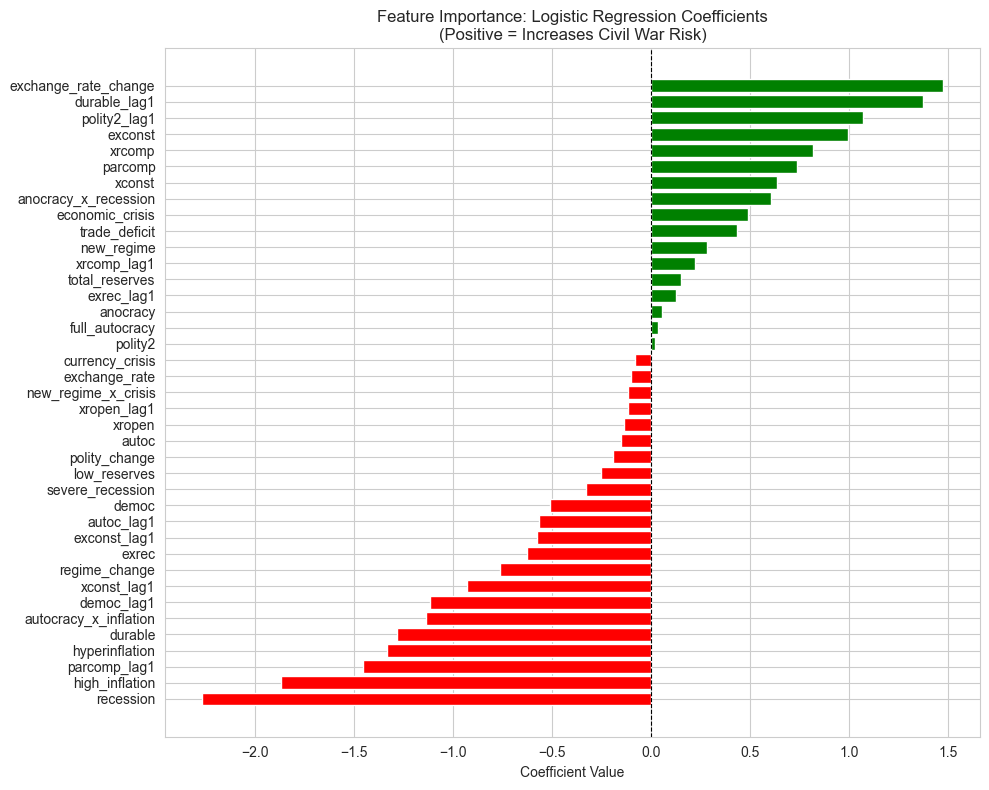

In [69]:
# ========================
# 8. BUILD LOGISTIC REGRESSION MODEL
# ========================

print("Building Logistic Regression model...")

# Since we have imbalanced classes, we'll use class_weight='balanced'
# This gives more weight to the minority class (civil war onsets)

# Basic logistic regression
lr_model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42
)

# Fit the model
lr_model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully!")

# Display feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE (Logistic Regression Coefficients)")
print("="*50)
print(coefficients)

# Visualize feature importance
plt.figure(figsize=(10, 8))
coefficients_sorted = coefficients.sort_values('Coefficient')
colors = ['red' if x < 0 else 'green' for x in coefficients_sorted['Coefficient']]
plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance: Logistic Regression Coefficients\n(Positive = Increases Civil War Risk)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

Evaluating model performance...

MODEL PERFORMANCE

TRAINING SET:
Accuracy: 0.8007
ROC-AUC: 0.8749
F1-Score: 0.0994

TEST SET:
Accuracy: 0.7704
ROC-AUC: 0.7098
F1-Score: 0.0537

CLASSIFICATION REPORT (Test Set):
                 precision    recall  f1-score   support

       No Onset       0.99      0.78      0.87       605
Civil War Onset       0.03      0.44      0.05         9

       accuracy                           0.77       614
      macro avg       0.51      0.61      0.46       614
   weighted avg       0.98      0.77      0.86       614


CONFUSION MATRIX (Test Set):
[[469 136]
 [  5   4]]


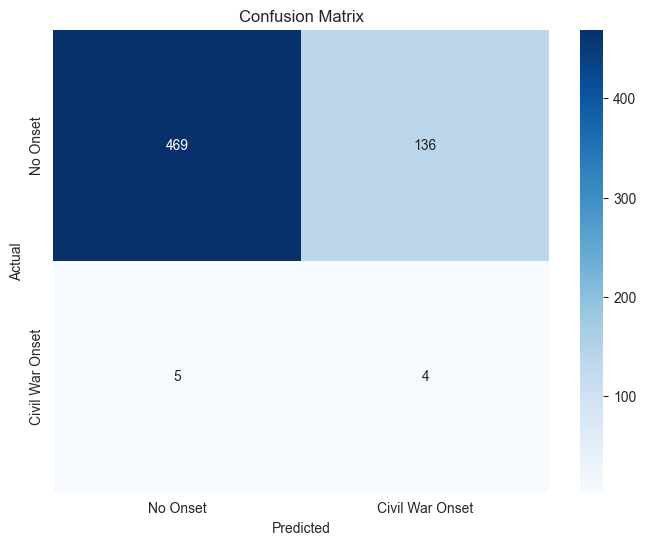

In [70]:
# ========================
# 9. MODEL EVALUATION
# ========================

print("Evaluating model performance...")

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

y_train_pred_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("\n" + "="*50)
print("MODEL PERFORMANCE")
print("="*50)

print("\nTRAINING SET:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")

print("\nTEST SET:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")

print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Onset', 'Civil War Onset']))

# Confusion Matrix
print("\nCONFUSION MATRIX (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Onset', 'Civil War Onset'],
            yticklabels=['No Onset', 'Civil War Onset'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Plotting ROC and Precision-Recall curves...


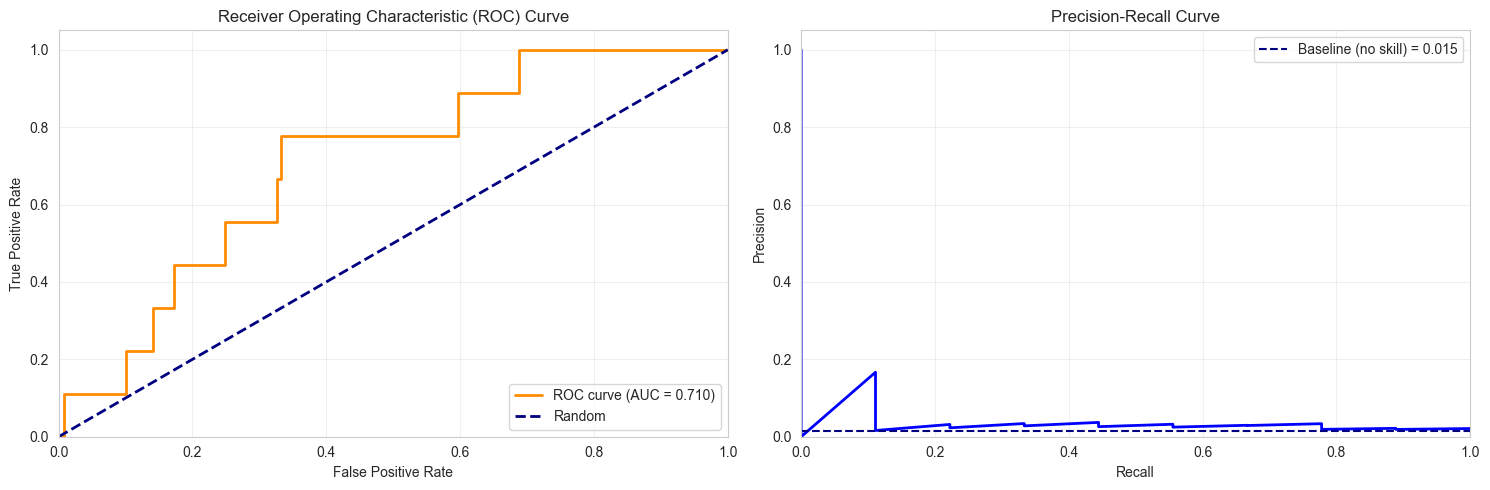

In [71]:
# ========================
# 10. ROC CURVE AND PRECISION-RECALL
# ========================

print("Plotting ROC and Precision-Recall curves...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall, precision, color='blue', lw=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].grid(alpha=0.3)

# Add baseline (random classifier)
baseline = y_test.sum() / len(y_test)
axes[1].axhline(y=baseline, color='navy', linestyle='--', 
                label=f'Baseline (no skill) = {baseline:.3f}')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [72]:
# ========================
# 11. CROSS-VALIDATION
# ========================

print("Performing cross-validation...")

cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, 
                             cv=5, scoring='roc_auc')

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("="*50)
print(f"ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f}")
print(f"Std ROC-AUC: {cv_scores.std():.4f}")

Performing cross-validation...

CROSS-VALIDATION RESULTS (5-Fold)
ROC-AUC Scores: [0.70661157 0.71989374 0.84858323 0.6714876  0.60455487]
Mean ROC-AUC: 0.7102
Std ROC-AUC: 0.0799


In [13]:
# ========================
# 12. HYPERPARAMETER TUNING (OPTIONAL)
# ========================

print("Tuning hyperparameters with GridSearchCV...")

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both L1 and L2
}

grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
print(grid_search.best_params_)
print(f"Best Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test_scaled)
y_test_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nBEST MODEL TEST SET PERFORMANCE:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_best):.4f}")

print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_test_pred_best, 
                           target_names=['No Onset', 'Civil War Onset']))

Tuning hyperparameters with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits



BEST HYPERPARAMETERS
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation ROC-AUC: 0.7193

BEST MODEL TEST SET PERFORMANCE:
Accuracy: 0.7182
ROC-AUC: 0.7041
F1-Score: 0.0366

Classification Report (Best Model):
                 precision    recall  f1-score   support

       No Onset       0.99      0.72      0.83      2957
Civil War Onset       0.02      0.47      0.04        34

       accuracy                           0.72      2991
      macro avg       0.51      0.60      0.44      2991
   weighted avg       0.98      0.72      0.83      2991



In [73]:
# ========================
# 13. SUMMARY AND KEY FINDINGS
# ========================

print("\n" + "="*70)
print("CIVIL WAR PREDICTION MODEL - SUMMARY")
print("="*70)

print("\nDATA SUMMARY:")
print(f"   • Total observations: {len(model_data_clean)}")
print(f"   • Civil war onsets: {y.sum()}")
print(f"   • Features used: {len(feature_names)}")
print(f"   • Time period: {model_data_clean['year'].min()} - {model_data_clean['year'].max()}")

print("\nMODEL PERFORMANCE:")
print(f"   • Test ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"   • Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"   • Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")

print("\nTOP RISK FACTORS (by coefficient magnitude):")
top_features = coefficients.head(5)
for idx, row in top_features.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"   • {row['Feature']}: {direction} civil war risk (coef: {row['Coefficient']:.4f})")

print("\nKEY INSIGHTS:")
print("   • Logistic regression provides interpretable coefficients")
print("   • Class imbalance addressed with balanced class weights")
print("   • Consider ensemble methods for improved performance")
print("   • Economic indicators could further enhance predictions")

print("\n" + "="*70)


CIVIL WAR PREDICTION MODEL - SUMMARY

DATA SUMMARY:
   • Total observations: 3068
   • Civil war onsets: 44
   • Features used: 39
   • Time period: 1996 - 2020

MODEL PERFORMANCE:
   • Test ROC-AUC: 0.7098
   • Test Accuracy: 0.7704
   • Test F1-Score: 0.0537

TOP RISK FACTORS (by coefficient magnitude):
   • recession: decreases civil war risk (coef: -2.2672)
   • high_inflation: decreases civil war risk (coef: -1.8713)
   • exchange_rate_change: increases civil war risk (coef: 1.4721)
   • parcomp_lag1: decreases civil war risk (coef: -1.4546)
   • durable_lag1: increases civil war risk (coef: 1.3690)

KEY INSIGHTS:
   • Logistic regression provides interpretable coefficients
   • Class imbalance addressed with balanced class weights
   • Consider ensemble methods for improved performance
   • Economic indicators could further enhance predictions



RUN 2

In [124]:
# ===================================================================
# RUN 2: ENHANCED FEATURE ENGINEERING (WITH ECONOMIC DATA)
# ===================================================================

print("="*70)
print("RUN 2: ENHANCED FEATURES (POLITICAL + ECONOMIC)")
print("="*70)

print("\nCreating advanced features for better prediction...")

# Start with the cleaned model_data that already has economic features
model_data_enhanced = model_data_clean.copy()

# FIX: Reset index to ensure ccode is a column, not index
model_data_enhanced = model_data_enhanced.reset_index(drop=True)

# Ensure ccode is a column
if 'ccode' not in model_data_enhanced.columns:
    if 'ccode' in model_data_enhanced.index.names:
        model_data_enhanced = model_data_enhanced.reset_index()

print(f"Starting with {model_data_enhanced.shape[1]} columns")
print(f"Columns: {model_data_enhanced.columns.tolist()[:10]}...")

# Verify ccode exists
if 'ccode' not in model_data_enhanced.columns:
    print("ERROR: ccode column not found!")
    print(f"Available columns: {model_data_enhanced.columns.tolist()}")
    raise ValueError("ccode column missing - check data structure")

# Get available political features
political_features = ['polity2', 'democ', 'autoc', 'durable', 'xconst', 
                      'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']
available_political = [col for col in political_features if col in model_data_enhanced.columns]

# Get available economic features
economic_features = [col for col in model_data_enhanced.columns if any(
    kw in col.lower() for kw in ['gdp', 'unemployment', 'inflation', 'trade', 
                                   'export', 'import', 'exchange', 'reserves', 
                                   'recession', 'crisis']
)]

print(f"Political features available: {len(available_political)}")
print(f"Economic features available: {len(economic_features)}")

# Sort for time-series operations (ensure ccode is a column)
model_data_enhanced = model_data_enhanced.sort_values(['ccode', 'year']).reset_index(drop=True)

# ==================
# 1. ADVANCED POLITICAL FEATURES
# ==================
print("\n1. Creating advanced political features...")

if 'polity2' in available_political:
    model_data_enhanced['anocracy'] = ((model_data_enhanced['polity2'] >= -5) & 
                                       (model_data_enhanced['polity2'] <= 5)).astype(int)
    model_data_enhanced['full_autocracy'] = (model_data_enhanced['polity2'] <= -6).astype(int)
    model_data_enhanced['full_democracy'] = (model_data_enhanced['polity2'] >= 6).astype(int)
    model_data_enhanced['polity_squared'] = model_data_enhanced['polity2'] ** 2
    print("   ✓ Regime type indicators")

if 'durable' in available_political:
    model_data_enhanced['new_regime'] = (model_data_enhanced['durable'] <= 2).astype(int)
    model_data_enhanced['very_new_regime'] = (model_data_enhanced['durable'] <= 1).astype(int)
    model_data_enhanced['unstable_regime'] = (model_data_enhanced['durable'] <= 5).astype(int)
    model_data_enhanced['log_durable'] = np.log1p(model_data_enhanced['durable'])
    print("   ✓ Regime stability indicators")

# ==================
# 2. MULTIPLE LAGS (Political)
# ==================
print("\n2. Creating lagged political features (1, 2, 3 years)...")

lag_count = 0
for col in available_political:
    if col in model_data_enhanced.columns:
        model_data_enhanced[f'{col}_lag1'] = model_data_enhanced.groupby('ccode')[col].shift(1)
        model_data_enhanced[f'{col}_lag2'] = model_data_enhanced.groupby('ccode')[col].shift(2)
        model_data_enhanced[f'{col}_lag3'] = model_data_enhanced.groupby('ccode')[col].shift(3)
        lag_count += 3

print(f"   ✓ Created {lag_count} lagged features")

# ==================
# 3. CHANGE FEATURES (Political)
# ==================
print("\n3. Creating political change indicators...")

if 'polity2' in available_political:
    model_data_enhanced['polity_change_1yr'] = model_data_enhanced.groupby('ccode')['polity2'].diff()
    model_data_enhanced['polity_change_2yr'] = model_data_enhanced.groupby('ccode')['polity2'].diff(2)
    model_data_enhanced['major_regime_change'] = (abs(model_data_enhanced['polity_change_1yr']) >= 3).astype(int)
    model_data_enhanced['massive_regime_change'] = (abs(model_data_enhanced['polity_change_1yr']) >= 5).astype(int)
    model_data_enhanced['democratization'] = (model_data_enhanced['polity_change_1yr'] > 0).astype(int)
    model_data_enhanced['autocratization'] = (model_data_enhanced['polity_change_1yr'] < 0).astype(int)
    print("   ✓ Regime change indicators")

if 'xconst' in available_political:
    model_data_enhanced['xconst_change'] = model_data_enhanced.groupby('ccode')['xconst'].diff()
    model_data_enhanced['xconst_decline'] = (model_data_enhanced['xconst_change'] < 0).astype(int)
    print("   ✓ Executive constraint changes")

# ==================
# 4. VOLATILITY FEATURES (Political)
# ==================
print("\n4. Creating political volatility measures...")

if 'polity2' in available_political:
    model_data_enhanced['polity_volatility_3yr'] = (
        model_data_enhanced.groupby('ccode')['polity2']
        .transform(lambda x: x.rolling(3, min_periods=1).std())
    )
    model_data_enhanced['polity_volatility_5yr'] = (
        model_data_enhanced.groupby('ccode')['polity2']
        .transform(lambda x: x.rolling(5, min_periods=1).std())
    )
    print("   ✓ Volatility measures")

# ==================
# 5. ECONOMIC LAGS (if not already present)
# ==================
print("\n5. Creating additional economic lags...")

key_economic = ['gdp_growth', 'unemployment_rate', 'inflation_rate', 
                'trade_balance', 'recession', 'economic_crisis']

econ_lag_count = 0
for econ_var in key_economic:
    if econ_var in model_data_enhanced.columns:
        # Add lags if not already present
        if f'{econ_var}_lag1' not in model_data_enhanced.columns:
            model_data_enhanced[f'{econ_var}_lag1'] = model_data_enhanced.groupby('ccode')[econ_var].shift(1)
            econ_lag_count += 1
        if f'{econ_var}_lag2' not in model_data_enhanced.columns:
            model_data_enhanced[f'{econ_var}_lag2'] = model_data_enhanced.groupby('ccode')[econ_var].shift(2)
            econ_lag_count += 1

print(f"   ✓ Created {econ_lag_count} additional economic lags")

# ==================
# 6. INTERACTION FEATURES (Political × Economic)
# ==================
print("\n6. Creating interaction features (Political × Economic)...")

interaction_count = 0

# Anocracy × Economic shocks
if 'anocracy' in model_data_enhanced.columns:
    if 'recession' in model_data_enhanced.columns:
        model_data_enhanced['anocracy_x_recession'] = (
            model_data_enhanced['anocracy'] * model_data_enhanced['recession']
        )
        interaction_count += 1
    if 'economic_crisis' in model_data_enhanced.columns:
        model_data_enhanced['anocracy_x_crisis'] = (
            model_data_enhanced['anocracy'] * model_data_enhanced['economic_crisis']
        )
        interaction_count += 1
    if 'high_inflation' in model_data_enhanced.columns:
        model_data_enhanced['anocracy_x_inflation'] = (
            model_data_enhanced['anocracy'] * model_data_enhanced['high_inflation']
        )
        interaction_count += 1

# New regime × Economic problems
if 'new_regime' in model_data_enhanced.columns:
    if 'recession' in model_data_enhanced.columns:
        model_data_enhanced['newregime_x_recession'] = (
            model_data_enhanced['new_regime'] * model_data_enhanced['recession']
        )
        interaction_count += 1
    if 'economic_crisis' in model_data_enhanced.columns:
        model_data_enhanced['newregime_x_crisis'] = (
            model_data_enhanced['new_regime'] * model_data_enhanced['economic_crisis']
        )
        interaction_count += 1

# Autocracy × Economic stress
if 'full_autocracy' in model_data_enhanced.columns:
    if 'high_inflation' in model_data_enhanced.columns:
        model_data_enhanced['autocracy_x_inflation'] = (
            model_data_enhanced['full_autocracy'] * model_data_enhanced['high_inflation']
        )
        interaction_count += 1
    if 'trade_deficit' in model_data_enhanced.columns:
        model_data_enhanced['autocracy_x_tradedeficit'] = (
            model_data_enhanced['full_autocracy'] * model_data_enhanced['trade_deficit']
        )
        interaction_count += 1

print(f"   ✓ Created {interaction_count} interaction features")

# ==================
# 7. HISTORICAL CONFLICT FEATURES
# ==================
print("\n7. Creating conflict history features...")

model_data_enhanced['civil_war_lag1'] = model_data_enhanced.groupby('ccode')['civil_war_onset'].shift(1)
model_data_enhanced['civil_war_lag2'] = model_data_enhanced.groupby('ccode')['civil_war_onset'].shift(2)
model_data_enhanced['civil_war_history_5yr'] = (
    model_data_enhanced.groupby('ccode')['civil_war_onset']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).sum())
)
print("   ✓ Historical conflict indicators")

# ==================
# FINAL RESET INDEX (Critical!)
# ==================
model_data_enhanced = model_data_enhanced.reset_index(drop=True)

# ==================
# SUMMARY
# ==================
print("\n" + "="*70)
print("ENHANCED FEATURE SUMMARY")
print("="*70)

total_features = model_data_enhanced.shape[1] - 3  # Exclude year, ccode, target
political_count = len([c for c in model_data_enhanced.columns 
                       if any(p in c for p in ['polity', 'democ', 'autoc', 'xconst', 'durable', 'regime'])])
economic_count = len([c for c in model_data_enhanced.columns 
                      if any(e in c.lower() for e in ['gdp', 'unemployment', 'inflation', 'trade', 
                                                        'export', 'import', 'exchange', 'reserves', 
                                                        'recession', 'crisis'])])
interaction_count = len([c for c in model_data_enhanced.columns if '_x_' in c])

print(f"Total enhanced features: {total_features}")
print(f"  Political features: {political_count}")
print(f"  Economic features: {economic_count}")
print(f"  Interaction features: {interaction_count}")

print(f"\nEnhanced feature engineering complete!")
print(f"   Shape: {model_data_enhanced.shape}")
print(f"   Civil war onsets: {model_data_enhanced['civil_war_onset'].sum()}")

RUN 2: ENHANCED FEATURES (POLITICAL + ECONOMIC)

Creating advanced features for better prediction...
Starting with 66 columns
Columns: ['year', 'ccode', 'civil_war_onset', 'polity2', 'democ', 'autoc', 'durable', 'xconst', 'xrcomp', 'xropen']...
Political features available: 10
Economic features available: 0

1. Creating advanced political features...
   ✓ Regime type indicators
   ✓ Regime stability indicators

2. Creating lagged political features (1, 2, 3 years)...
   ✓ Created 30 lagged features

3. Creating political change indicators...
   ✓ Regime change indicators
   ✓ Executive constraint changes

4. Creating political volatility measures...
   ✓ Volatility measures

5. Creating additional economic lags...
   ✓ Created 0 additional economic lags

6. Creating interaction features (Political × Economic)...
   ✓ Created 0 interaction features

7. Creating conflict history features...
   ✓ Historical conflict indicators

ENHANCED FEATURE SUMMARY
Total enhanced features: 64
  Politi

In [125]:
# ===================================================================
# ENHANCED DATA PREPARATION (WITH ECONOMIC FEATURES)
# ===================================================================

print("="*70)
print("PREPARING ENHANCED DATASET")
print("="*70)

# Remove rows with too many missing values (more lenient for economic data)
print("\nStep 1: Handling missing values...")
print(f"Initial shape: {model_data_enhanced.shape}")

# Keep rows with at least 60% non-missing (more lenient because economic data has gaps)
threshold = model_data_enhanced.shape[1] * 0.6
row_non_null_counts = model_data_enhanced.notna().sum(axis=1)
model_data_clean_enh = model_data_enhanced[row_non_null_counts >= threshold].copy()

print(f"After removing sparse rows: {model_data_clean_enh.shape}")
print(f"Civil war onsets remaining: {model_data_clean_enh['civil_war_onset'].sum()}")

# Fill remaining missing values
print("\nStep 2: Imputing remaining missing values...")

# Group features by type for appropriate imputation
political_cols = [c for c in model_data_clean_enh.columns 
                  if any(p in c for p in ['polity', 'democ', 'autoc', 'xconst', 'durable', 'regime'])]
economic_cols = [c for c in model_data_clean_enh.columns 
                 if any(e in c.lower() for e in ['gdp', 'unemployment', 'inflation', 'trade', 
                                                   'export', 'import', 'exchange', 'reserves', 
                                                   'recession', 'crisis'])]

# Forward fill within countries (makes sense for time-series)
for country in model_data_clean_enh['ccode'].unique():
    mask = model_data_clean_enh['ccode'] == country
    model_data_clean_enh.loc[mask] = model_data_clean_enh.loc[mask].fillna(method='ffill')

# Backward fill any remaining
model_data_clean_enh = model_data_clean_enh.fillna(method='bfill')

# For any still missing, use median (more robust than mean for economic data)
for col in model_data_clean_enh.columns:
    if col not in ['year', 'ccode', 'civil_war_onset', 'country', 'country_name']:
        if model_data_clean_enh[col].isna().any():
            if model_data_clean_enh[col].dtype in ['float64', 'int64']:
                model_data_clean_enh[col].fillna(model_data_clean_enh[col].median(), inplace=True)

# Final dropna for any categorical columns
model_data_clean_enh = model_data_clean_enh.dropna()

print(f"After imputation: {model_data_clean_enh.shape}")
print(f"Civil war onsets: {model_data_clean_enh['civil_war_onset'].sum()}")

# Separate features and target
exclude_cols = ['year', 'ccode', 'civil_war_onset', 'country', 'country_name']
feature_cols_enh = [c for c in model_data_clean_enh.columns if c not in exclude_cols]

X_enhanced = model_data_clean_enh[feature_cols_enh].copy()
y_enhanced = model_data_clean_enh['civil_war_onset'].copy()

print(f"\nEnhanced dataset ready:")
print(f"   Features (X): {X_enhanced.shape}")
print(f"   Target (y): {y_enhanced.shape}")
print(f"   Total features: {len(feature_cols_enh)}")

# Breakdown by category
political_in_model = [c for c in feature_cols_enh if any(p in c for p in ['polity', 'democ', 'autoc', 'xconst', 'durable', 'regime'])]
economic_in_model = [c for c in feature_cols_enh if any(e in c.lower() for e in ['gdp', 'unemployment', 'inflation', 'trade', 'export', 'import', 'exchange', 'reserves', 'recession', 'crisis'])]
interaction_in_model = [c for c in feature_cols_enh if '_x_' in c]

print(f"\nFeature breakdown:")
print(f"   Political: {len(political_in_model)}")
print(f"   Economic: {len(economic_in_model)}")
print(f"   Interactions: {len(interaction_in_model)}")
print(f"   Other: {len(feature_cols_enh) - len(political_in_model) - len(economic_in_model) - len(interaction_in_model)}")

print(f"\n Verification - Economic features in model:")
if len(economic_in_model) > 0:
    print(f"   YES! {len(economic_in_model)} economic features included")
    for feat in economic_in_model[:10]:
        print(f"      • {feat}")
    if len(economic_in_model) > 10:
        print(f"      ... and {len(economic_in_model)-10} more")
else:
    print(f"   WARNING: No economic features found!")

print(f"\nClass distribution:")
print(f"   No onset: {(y_enhanced == 0).sum():,}")
print(f"   Onset: {(y_enhanced == 1).sum()}")
print(f"   Imbalance ratio: {(y_enhanced == 0).sum() / (y_enhanced == 1).sum():.1f}:1")

PREPARING ENHANCED DATASET

Step 1: Handling missing values...
Initial shape: (16429, 67)
After removing sparse rows: (16239, 67)
Civil war onsets remaining: 176

Step 2: Imputing remaining missing values...
After imputation: (16239, 67)
Civil war onsets: 176

Enhanced dataset ready:
   Features (X): (16239, 64)
   Target (y): (16239,)
   Total features: 64

Feature breakdown:
   Political: 41
   Economic: 0
   Interactions: 1
   Other: 22

 Verification - Economic features in model:

Class distribution:
   No onset: 16,063
   Onset: 176
   Imbalance ratio: 91.3:1


In [83]:
# ========================
# SPLIT AND APPLY SMOTE
# ========================

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("Splitting data and applying SMOTE...")

# Split first
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print(f"Training set size: {X_train_enh.shape[0]} ({y_train_enh.sum()} onsets)")
print(f"Test set size: {X_test_enh.shape[0]} ({y_test_enh.sum()} onsets)")

# Standardize features
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

# Apply SMOTE to training data only (never to test data!)
# Combine SMOTE with undersampling to balance the classes
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Create synthetic minority samples
undersampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Remove majority samples

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_enh_scaled, y_train_enh)

# Apply undersampling
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nAfter SMOTE + Undersampling:")
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Class distribution: {pd.Series(y_train_resampled).value_counts()}")
print(f"Class balance: {pd.Series(y_train_resampled).value_counts(normalize=True)}")

Splitting data and applying SMOTE...
Training set size: 12991 (141 onsets)
Test set size: 3248 (35 onsets)

After SMOTE + Undersampling:
Training set size: 14456
Class distribution: civil_war_onset
0    8031
1    6425
Name: count, dtype: int64
Class balance: civil_war_onset
0    0.555548
1    0.444452
Name: proportion, dtype: float64


Training improved Logistic Regression model...
Improved model trained!

IMPROVED MODEL PERFORMANCE

TRAINING SET:
Accuracy: 0.8196
ROC-AUC: 0.8137
F1-Score: 0.0713

TEST SET:
Accuracy: 0.8070
ROC-AUC: 0.6843
F1-Score: 0.0398

COMPARISON WITH BASELINE:
ROC-AUC Improvement: -0.0193
F1-Score Improvement: -0.0005

CLASSIFICATION REPORT (Test Set):
                 precision    recall  f1-score   support

       No Onset       0.99      0.81      0.89      3213
Civil War Onset       0.02      0.37      0.04        35

       accuracy                           0.81      3248
      macro avg       0.51      0.59      0.47      3248
   weighted avg       0.98      0.81      0.88      3248


CONFUSION MATRIX (Test Set):
[[2608  605]
 [  22   13]]


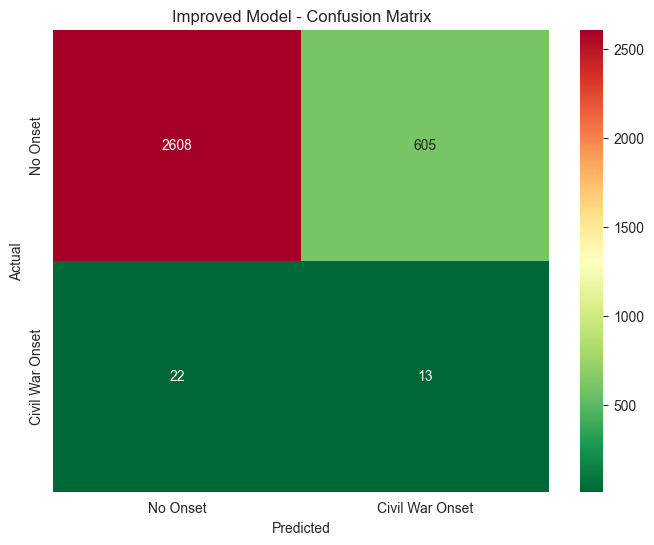

In [84]:
# ========================
# IMPROVED LOGISTIC REGRESSION MODEL
# ========================

print("Training improved Logistic Regression model...")

# Train model with balanced data
lr_model_improved = LogisticRegression(
    penalty='l2',
    C=0.1,  # Regularization
    class_weight=None, 
    max_iter=2000,
    random_state=42,
    solver='lbfgs'
)

lr_model_improved.fit(X_train_resampled, y_train_resampled)

print("Improved model trained!")

# Make predictions
y_train_pred_imp = lr_model_improved.predict(X_train_enh_scaled)
y_test_pred_imp = lr_model_improved.predict(X_test_enh_scaled)

y_train_pred_proba_imp = lr_model_improved.predict_proba(X_train_enh_scaled)[:, 1]
y_test_pred_proba_imp = lr_model_improved.predict_proba(X_test_enh_scaled)[:, 1]

# Evaluate
print("\n" + "="*70)
print("IMPROVED MODEL PERFORMANCE")
print("="*70)

print("\nTRAINING SET:")
print(f"Accuracy: {accuracy_score(y_train_enh, y_train_pred_imp):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train_enh, y_train_pred_proba_imp):.4f}")
print(f"F1-Score: {f1_score(y_train_enh, y_train_pred_imp):.4f}")

print("\nTEST SET:")
print(f"Accuracy: {accuracy_score(y_test_enh, y_test_pred_imp):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_imp):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_test_pred_imp):.4f}")

print("\nCOMPARISON WITH BASELINE:")
print(f"ROC-AUC Improvement: {roc_auc_score(y_test_enh, y_test_pred_proba_imp) - 0.7036:.4f}")
print(f"F1-Score Improvement: {f1_score(y_test_enh, y_test_pred_imp) - 0.0403:.4f}")

print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test_enh, y_test_pred_imp, target_names=['No Onset', 'Civil War Onset']))

# Confusion Matrix
cm_imp = confusion_matrix(y_test_enh, y_test_pred_imp)
print("\nCONFUSION MATRIX (Test Set):")
print(cm_imp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='RdYlGn_r', 
            xticklabels=['No Onset', 'Civil War Onset'],
            yticklabels=['No Onset', 'Civil War Onset'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Improved Model - Confusion Matrix')
plt.show()

Analyzing feature importance...

TOP 20 MOST IMPORTANT FEATURES
              Feature  Coefficient  Abs_Coefficient
25         autoc_lag2     2.004809         2.004809
26         autoc_lag3    -1.958802         1.958802
8               exrec     1.120865         1.120865
35        xrcomp_lag3    -0.950811         0.950811
34        xrcomp_lag2     0.837353         0.837353
1               democ    -0.819824         0.819824
5              xrcomp    -0.724508         0.724508
23         democ_lag3    -0.696896         0.696896
21         democ_lag1    -0.667552         0.667552
22         democ_lag2     0.646419         0.646419
0             polity2     0.628263         0.628263
29       durable_lag3    -0.624138         0.624138
43         exrec_lag2    -0.597946         0.597946
18       polity2_lag1     0.585678         0.585678
62  civil_war_history     0.561795         0.561795
41       parcomp_lag3    -0.508454         0.508454
42         exrec_lag1     0.480360         0.480360


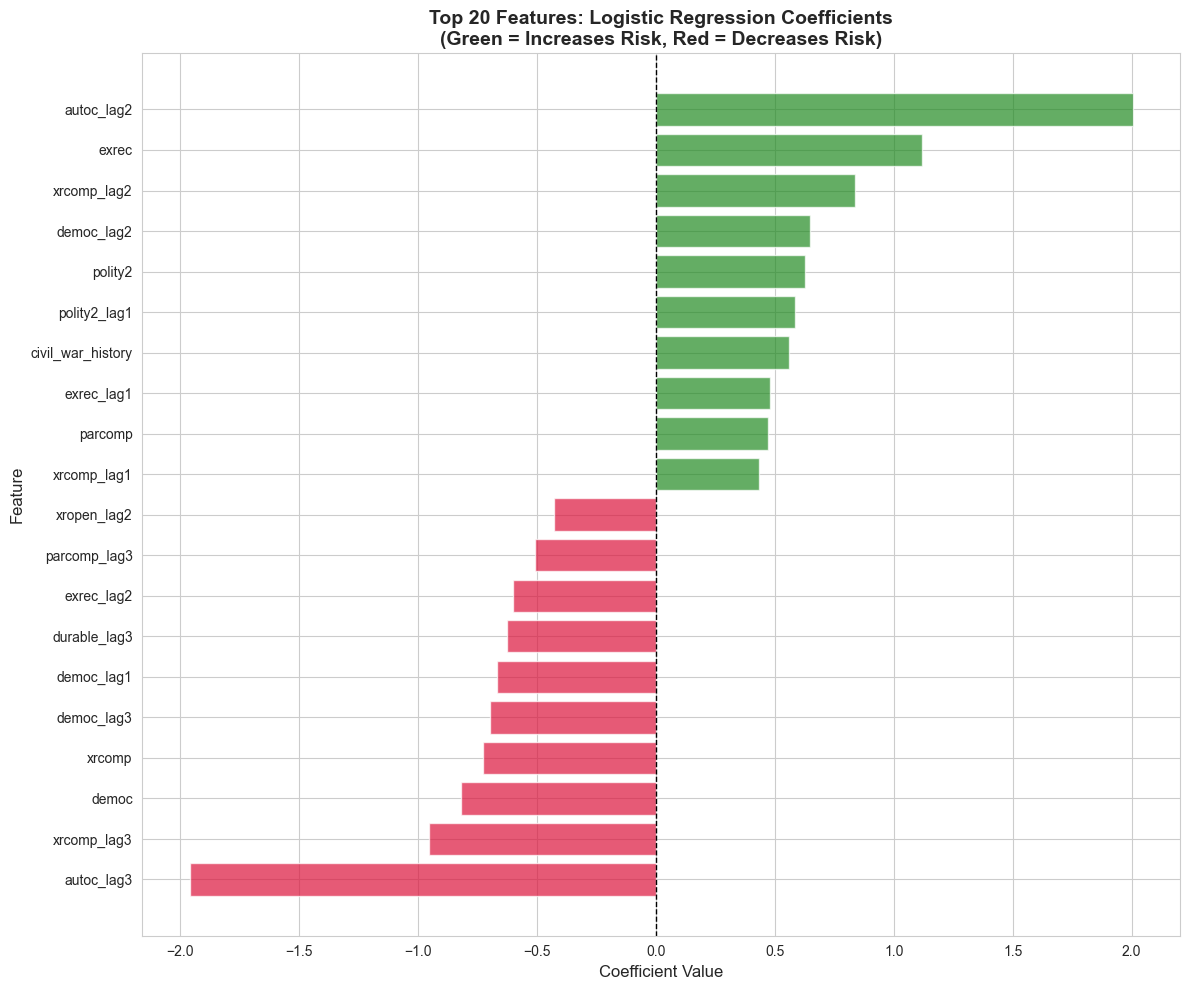

In [85]:
# ========================
# FEATURE IMPORTANCE
# ========================

print("Analyzing feature importance...")

feature_names_enh = X_enhanced.columns.tolist()

coefficients_enh = pd.DataFrame({
    'Feature': feature_names_enh,
    'Coefficient': lr_model_improved.coef_[0],
    'Abs_Coefficient': abs(lr_model_improved.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
print(coefficients_enh.head(20))

# Visualize top features
plt.figure(figsize=(12, 10))
top_20_features = coefficients_enh.head(20).sort_values('Coefficient')
colors = ['crimson' if x < 0 else 'forestgreen' for x in top_20_features['Coefficient']]
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features: Logistic Regression Coefficients\n(Green = Increases Risk, Red = Decreases Risk)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

Training ensemble models for comparison...

1. Random Forest...
   Accuracy: 0.9744
   ROC-AUC: 0.6895
   F1-Score: 0.0879

2. Gradient Boosting...
   Accuracy: 0.9858
   ROC-AUC: 0.6335
   F1-Score: 0.0417

MODEL COMPARISON
                 Model  Accuracy   ROC-AUC  F1-Score
0          Baseline LR  0.713100  0.703600  0.040300
1  Improved LR (SMOTE)  0.806958  0.684287  0.039816
2        Random Forest  0.974446  0.689480  0.087912
3    Gradient Boosting  0.985837  0.633516  0.041667


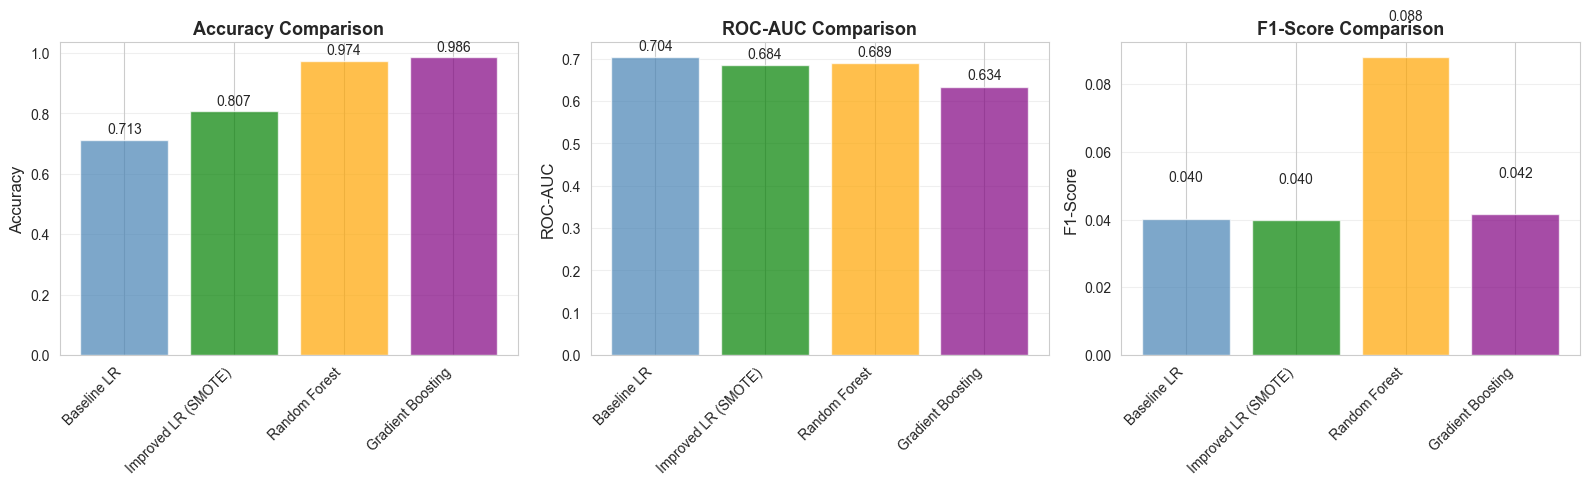

In [86]:
# ========================
# ENSEMBLE MODELS FOR COMPARISON
# ========================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer

print("Training ensemble models for comparison...")

# Random Forest
print("\n1. Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_enh_scaled, y_train_enh)

y_test_pred_rf = rf_model.predict(X_test_enh_scaled)
y_test_pred_proba_rf = rf_model.predict_proba(X_test_enh_scaled)[:, 1]

print(f"   Accuracy: {accuracy_score(y_test_enh, y_test_pred_rf):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_rf):.4f}")
print(f"   F1-Score: {f1_score(y_test_enh, y_test_pred_rf):.4f}")

# Gradient Boosting
print("\n2. Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_resampled, y_train_resampled)

y_test_pred_gb = gb_model.predict(X_test_enh_scaled)
y_test_pred_proba_gb = gb_model.predict_proba(X_test_enh_scaled)[:, 1]

print(f"   Accuracy: {accuracy_score(y_test_enh, y_test_pred_gb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_gb):.4f}")
print(f"   F1-Score: {f1_score(y_test_enh, y_test_pred_gb):.4f}")

# Model Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

models_comparison = pd.DataFrame({
    'Model': ['Baseline LR', 'Improved LR (SMOTE)', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        0.7131,
        accuracy_score(y_test_enh, y_test_pred_imp),
        accuracy_score(y_test_enh, y_test_pred_rf),
        accuracy_score(y_test_enh, y_test_pred_gb)
    ],
    'ROC-AUC': [
        0.7036,
        roc_auc_score(y_test_enh, y_test_pred_proba_imp),
        roc_auc_score(y_test_enh, y_test_pred_proba_rf),
        roc_auc_score(y_test_enh, y_test_pred_proba_gb)
    ],
    'F1-Score': [
        0.0403,
        f1_score(y_test_enh, y_test_pred_imp),
        f1_score(y_test_enh, y_test_pred_rf),
        f1_score(y_test_enh, y_test_pred_gb)
    ]
})

print(models_comparison)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, metric in enumerate(['Accuracy', 'ROC-AUC', 'F1-Score']):
    axes[idx].bar(models_comparison['Model'], models_comparison[metric], 
                  color=['steelblue', 'green', 'orange', 'purple'], alpha=0.7)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].set_xticklabels(models_comparison['Model'], rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(models_comparison[metric]):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Finding optimal classification threshold...

Optimal Threshold: 0.8350
Max F1-Score: 0.1022

PERFORMANCE WITH OPTIMAL THRESHOLD
Accuracy: 0.9626
ROC-AUC: 0.6811
F1-Score: 0.1022
Precision: 0.0693
Recall: 0.1944

Classification Report (Optimal Threshold):
                 precision    recall  f1-score   support

       No Onset       0.99      0.97      0.98      3250
Civil War Onset       0.07      0.19      0.10        36

       accuracy                           0.96      3286
      macro avg       0.53      0.58      0.54      3286
   weighted avg       0.98      0.96      0.97      3286



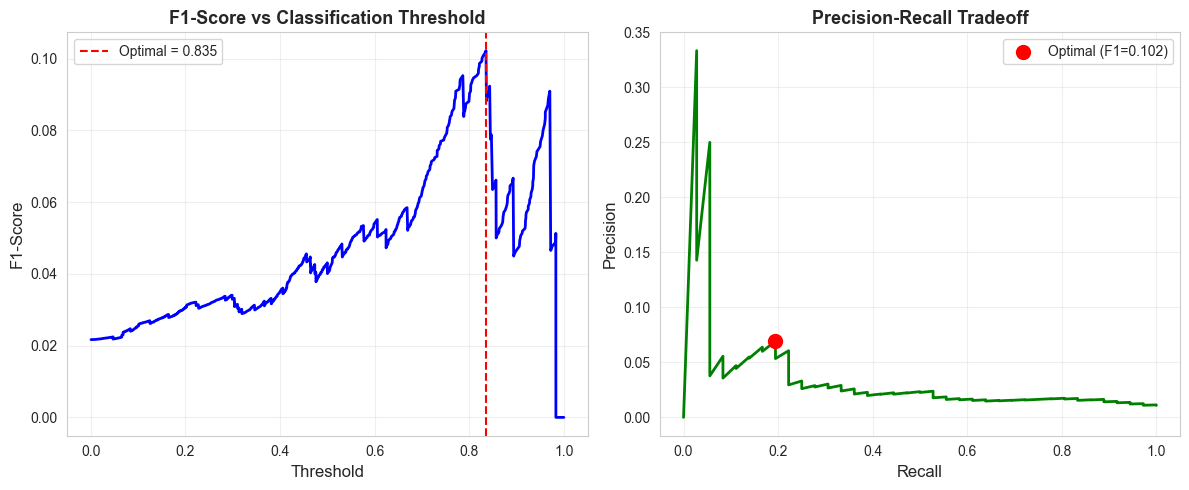

In [21]:
# ========================
# THRESHOLD OPTIMIZATION
# ========================

print("Finding optimal classification threshold...")

# Calculate precision-recall for different thresholds
precision, recall, thresholds_pr = precision_recall_curve(y_test_enh, y_test_pred_proba_imp)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find optimal threshold (max F1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1-Score: {f1_scores[optimal_idx]:.4f}")

# Apply optimal threshold
y_test_pred_optimal = (y_test_pred_proba_imp >= optimal_threshold).astype(int)

print("\n" + "="*70)
print("PERFORMANCE WITH OPTIMAL THRESHOLD")
print("="*70)
print(f"Accuracy: {accuracy_score(y_test_enh, y_test_pred_optimal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_imp):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_test_pred_optimal):.4f}")
print(f"Precision: {precision[optimal_idx]:.4f}")
print(f"Recall: {recall[optimal_idx]:.4f}")

print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test_enh, y_test_pred_optimal, target_names=['No Onset', 'Civil War Onset']))

# Plot threshold vs F1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds_pr, f1_scores[:-1], 'b-', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal = {optimal_threshold:.3f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score vs Classification Threshold', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall[:-1], precision[:-1], 'g-', linewidth=2)
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', s=100, zorder=5,
            label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Tradeoff', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

ATTEMPT 3

TECHNIQUE 1: OPTIMIZING CLASS WEIGHTS
Weight= 10 | Precision: 0.0556 | Recall: 0.0556 | F1: 0.0556 | ROC-AUC: 0.7176
Weight= 20 | Precision: 0.0496 | Recall: 0.1667 | F1: 0.0764 | ROC-AUC: 0.7162
Weight= 50 | Precision: 0.0296 | Recall: 0.3056 | F1: 0.0541 | ROC-AUC: 0.7110
Weight=100 | Precision: 0.0247 | Recall: 0.5000 | F1: 0.0470 | ROC-AUC: 0.7054
Weight=150 | Precision: 0.0176 | Recall: 0.6667 | F1: 0.0343 | ROC-AUC: 0.6994
Weight=200 | Precision: 0.0178 | Recall: 0.8333 | F1: 0.0349 | ROC-AUC: 0.6967
Weight=250 | Precision: 0.0166 | Recall: 0.8611 | F1: 0.0326 | ROC-AUC: 0.6947
Weight=300 | Precision: 0.0159 | Recall: 0.8889 | F1: 0.0312 | ROC-AUC: 0.6929

Best F1-Score: Weight=20
  Precision: 0.0496
  Recall: 0.1667
  F1-Score: 0.0764

Best Recall: Weight=300
  Precision: 0.0159
  Recall: 0.8889
  F1-Score: 0.0312


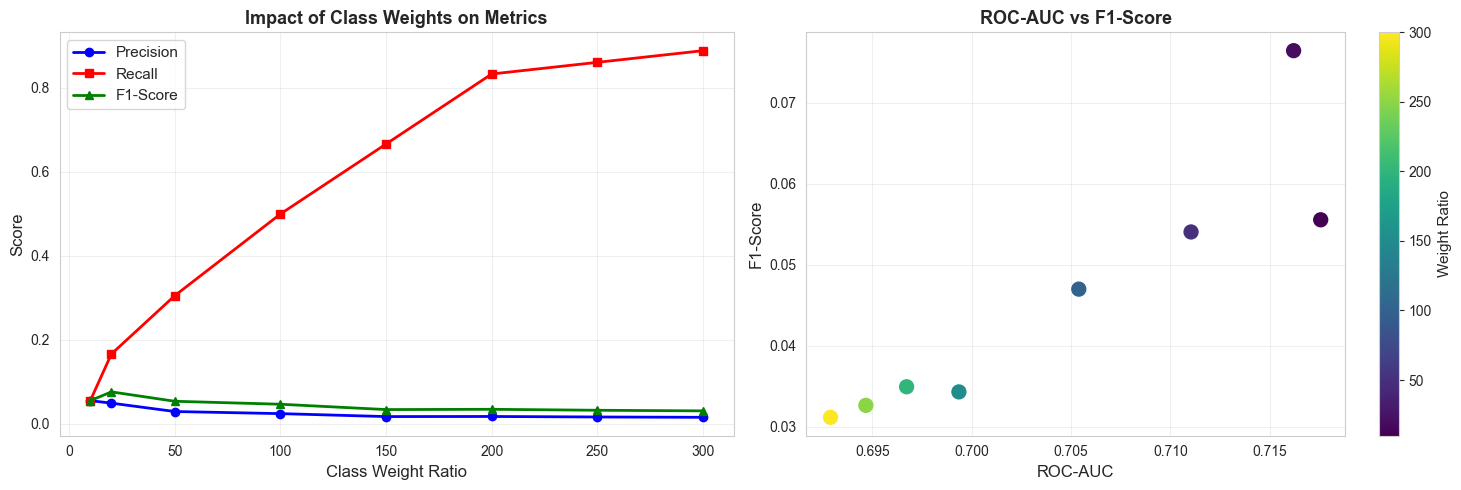

In [22]:
# ===================================================================
# ADVANCED TECHNIQUE 1: FINE-TUNED CLASS WEIGHTS
# ===================================================================

print("="*70)
print("TECHNIQUE 1: OPTIMIZING CLASS WEIGHTS")
print("="*70)

# Instead of 'balanced', we'll try different weight ratios
# to find the sweet spot for precision-recall balance

weight_ratios = [10, 20, 50, 100, 150, 200, 250, 300]
results = []

for ratio in weight_ratios:
    # Create custom class weights
    class_weights = {0: 1, 1: ratio}
    
    # Train model with custom weights
    lr_weighted = LogisticRegression(
        class_weight=class_weights,
        max_iter=2000,
        random_state=42,
        C=0.1
    )
    lr_weighted.fit(X_train_enh_scaled, y_train_enh)
    
    # Predict
    y_pred = lr_weighted.predict(X_test_enh_scaled)
    y_pred_proba = lr_weighted.predict_proba(X_test_enh_scaled)[:, 1]
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score
    
    precision = precision_score(y_test_enh, y_pred, zero_division=0)
    recall = recall_score(y_test_enh, y_pred)
    f1 = f1_score(y_test_enh, y_pred)
    roc_auc = roc_auc_score(y_test_enh, y_pred_proba)
    
    results.append({
        'Weight Ratio': ratio,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"Weight={ratio:3d} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find best configuration
best_f1_idx = results_df['F1-Score'].idxmax()
best_recall_idx = results_df['Recall'].idxmax()

print("\n" + "="*70)
print(f"Best F1-Score: Weight={results_df.loc[best_f1_idx, 'Weight Ratio']:.0f}")
print(f"  Precision: {results_df.loc[best_f1_idx, 'Precision']:.4f}")
print(f"  Recall: {results_df.loc[best_f1_idx, 'Recall']:.4f}")
print(f"  F1-Score: {results_df.loc[best_f1_idx, 'F1-Score']:.4f}")

print(f"\nBest Recall: Weight={results_df.loc[best_recall_idx, 'Weight Ratio']:.0f}")
print(f"  Precision: {results_df.loc[best_recall_idx, 'Precision']:.4f}")
print(f"  Recall: {results_df.loc[best_recall_idx, 'Recall']:.4f}")
print(f"  F1-Score: {results_df.loc[best_recall_idx, 'F1-Score']:.4f}")

# Visualize tradeoffs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Precision-Recall tradeoff
axes[0].plot(results_df['Weight Ratio'], results_df['Precision'], 'b-o', label='Precision', linewidth=2)
axes[0].plot(results_df['Weight Ratio'], results_df['Recall'], 'r-s', label='Recall', linewidth=2)
axes[0].plot(results_df['Weight Ratio'], results_df['F1-Score'], 'g-^', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Class Weight Ratio', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Impact of Class Weights on Metrics', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# F1 vs ROC-AUC
axes[1].scatter(results_df['ROC-AUC'], results_df['F1-Score'], 
                c=results_df['Weight Ratio'], cmap='viridis', s=100)
axes[1].set_xlabel('ROC-AUC', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('ROC-AUC vs F1-Score', fontsize=13, fontweight='bold')
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Weight Ratio', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


TECHNIQUE 2: ENSEMBLE VOTING CLASSIFIER
Training ensemble (this may take a few minutes)...

ENSEMBLE VOTING RESULTS:
Accuracy: 0.9127
Precision: 0.0264
Recall: 0.1944
F1-Score: 0.0465
ROC-AUC: 0.6637

Detailed Classification Report:
                 precision    recall  f1-score   support

       No Onset       0.99      0.92      0.95      3250
Civil War Onset       0.03      0.19      0.05        36

       accuracy                           0.91      3286
      macro avg       0.51      0.56      0.50      3286
   weighted avg       0.98      0.91      0.94      3286



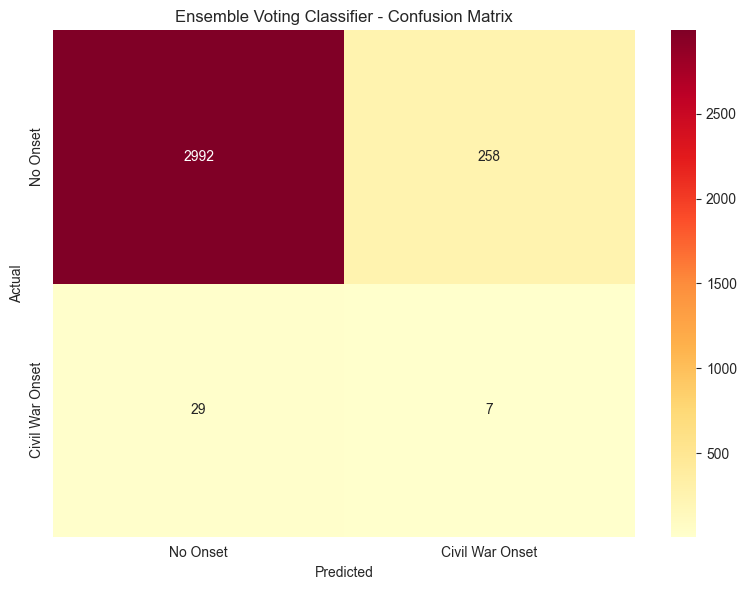

In [25]:
# ===================================================================
# ADVANCED TECHNIQUE 2: ENSEMBLE VOTING CLASSIFIER
# ===================================================================

print("\n" + "="*70)
print("TECHNIQUE 2: ENSEMBLE VOTING CLASSIFIER")
print("="*70)

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Define multiple diverse classifiers
clf1 = LogisticRegression(
    class_weight={0: 1, 1: 200},
    max_iter=2000,
    C=0.1,
    random_state=42
)

clf2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced_subsample',
    random_state=42,
    min_samples_leaf=3
)

clf3 = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=100,  # Handle imbalance
    random_state=42,
    eval_metric='logloss'
)

clf4 = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

# Create voting ensemble (soft voting uses probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('rf', clf2),
        ('xgb', clf3),
        ('gb', clf4)
    ],
    voting='soft',  # Use probability averaging
    weights=[2, 1, 1.5, 1]  # Give more weight to LR and XGB
)

print("Training ensemble (this may take a few minutes)...")
voting_clf.fit(X_train_enh_scaled, y_train_enh)

# Predict
y_pred_voting = voting_clf.predict(X_test_enh_scaled)
y_pred_proba_voting = voting_clf.predict_proba(X_test_enh_scaled)[:, 1]

# Evaluate
print("\nENSEMBLE VOTING RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_enh, y_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test_enh, y_pred_voting, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_enh, y_pred_voting):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_pred_voting):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_pred_proba_voting):.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test_enh, y_pred_voting, 
                           target_names=['No Onset', 'Civil War Onset']))

# Confusion matrix
cm_voting = confusion_matrix(y_test_enh, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['No Onset', 'Civil War Onset'],
            yticklabels=['No Onset', 'Civil War Onset'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Ensemble Voting Classifier - Confusion Matrix')
plt.tight_layout()
plt.show()

In [26]:
# ===================================================================
# ADVANCED TECHNIQUE 3: FOCAL LOSS FOR HARD EXAMPLES
# ===================================================================

print("\n" + "="*70)
print("TECHNIQUE 3: CUSTOM FOCAL LOSS OPTIMIZATION")
print("="*70)

from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize

class FocalLossLogisticRegression(BaseEstimator, ClassifierMixin):
    """
    Logistic Regression with Focal Loss to focus on hard-to-classify examples
    Focal Loss: FL(p) = -(1-p)^gamma * log(p)
    """
    def __init__(self, gamma=2.0, alpha=0.25, C=1.0, max_iter=1000):
        self.gamma = gamma
        self.alpha = alpha
        self.C = C
        self.max_iter = max_iter
        self.coef_ = None
        self.intercept_ = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def _focal_loss(self, y_true, y_pred_proba):
        """Calculate focal loss"""
        epsilon = 1e-7
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        
        # Focal loss computation
        pt = np.where(y_true == 1, y_pred_proba, 1 - y_pred_proba)
        focal_weight = (1 - pt) ** self.gamma
        
        # Cross entropy
        ce_loss = -np.log(pt)
        
        # Focal loss
        focal_loss = self.alpha * focal_weight * ce_loss
        
        return np.mean(focal_loss)
    
    def _objective(self, params, X, y):
        """Objective function to minimize"""
        self.coef_ = params[:-1].reshape(1, -1)
        self.intercept_ = params[-1]
        
        # Predictions
        z = X.dot(self.coef_.T) + self.intercept_
        y_pred_proba = self._sigmoid(z).ravel()
        
        # Focal loss + L2 regularization
        loss = self._focal_loss(y, y_pred_proba) + (1 / (2 * self.C)) * np.sum(self.coef_ ** 2)
        
        return loss
    
    def fit(self, X, y):
        """Fit the model using focal loss"""
        n_features = X.shape[1]
        
        # Initialize parameters (use standard LR for initialization)
        lr_init = LogisticRegression(max_iter=100)
        lr_init.fit(X, y)
        init_params = np.append(lr_init.coef_.ravel(), lr_init.intercept_)
        
        # Optimize with focal loss
        result = minimize(
            self._objective,
            init_params,
            args=(X, y),
            method='L-BFGS-B',
            options={'maxiter': self.max_iter}
        )
        
        self.coef_ = result.x[:-1].reshape(1, -1)
        self.intercept_ = result.x[-1]
        
        return self
    
    def predict_proba(self, X):
        """Predict probabilities"""
        z = X.dot(self.coef_.T) + self.intercept_
        prob_1 = self._sigmoid(z).ravel()
        prob_0 = 1 - prob_1
        return np.column_stack([prob_0, prob_1])
    
    def predict(self, X):
        """Predict class labels"""
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Train focal loss model
print("Training Focal Loss Logistic Regression...")
print("(This may take a minute...)")

focal_model = FocalLossLogisticRegression(
    gamma=2.0,      # Focus on hard examples
    alpha=0.75,     # Weight for positive class
    C=1.0,
    max_iter=500
)

focal_model.fit(X_train_enh_scaled, y_train_enh.values)

# Predict
y_pred_focal = focal_model.predict(X_test_enh_scaled)
y_pred_proba_focal = focal_model.predict_proba(X_test_enh_scaled)[:, 1]

print("\nFOCAL LOSS MODEL RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_enh, y_pred_focal):.4f}")
print(f"Precision: {precision_score(y_test_enh, y_pred_focal, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_enh, y_pred_focal):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_pred_focal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_pred_proba_focal):.4f}")


TECHNIQUE 3: CUSTOM FOCAL LOSS OPTIMIZATION
Training Focal Loss Logistic Regression...
(This may take a minute...)

FOCAL LOSS MODEL RESULTS:
Accuracy: 0.9890
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.7101


In [127]:
# ===================================================================
# ADVANCED TECHNIQUE 3: FOCAL LOSS FOR HARD EXAMPLES
# ===================================================================

print("\n" + "="*70)
print("TECHNIQUE 3: CUSTOM FOCAL LOSS OPTIMIZATION")
print("="*70)

from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize

class FocalLossLogisticRegression(BaseEstimator, ClassifierMixin):
    """
    Logistic Regression with Focal Loss to focus on hard-to-classify examples
    Focal Loss: FL(p) = -(1-p)^gamma * log(p)
    """
    def __init__(self, gamma=2.0, alpha=0.25, C=1.0, max_iter=1000):
        self.gamma = gamma
        self.alpha = alpha
        self.C = C
        self.max_iter = max_iter
        self.coef_ = None
        self.intercept_ = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def _focal_loss(self, y_true, y_pred_proba):
        """Calculate focal loss"""
        epsilon = 1e-7
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        
        # Focal loss computation
        pt = np.where(y_true == 1, y_pred_proba, 1 - y_pred_proba)
        focal_weight = (1 - pt) ** self.gamma
        
        # Cross entropy
        ce_loss = -np.log(pt)
        
        # Focal loss
        focal_loss = self.alpha * focal_weight * ce_loss
        
        return np.mean(focal_loss)
    
    def _objective(self, params, X, y):
        """Objective function to minimize"""
        self.coef_ = params[:-1].reshape(1, -1)
        self.intercept_ = params[-1]
        
        # Predictions
        z = X.dot(self.coef_.T) + self.intercept_
        y_pred_proba = self._sigmoid(z).ravel()
        
        # Focal loss + L2 regularization
        loss = self._focal_loss(y, y_pred_proba) + (1 / (2 * self.C)) * np.sum(self.coef_ ** 2)
        
        return loss
    
    def fit(self, X, y):
        """Fit the model using focal loss"""
        n_features = X.shape[1]
        
        # Initialize parameters (use standard LR for initialization)
        lr_init = LogisticRegression(max_iter=100)
        lr_init.fit(X, y)
        init_params = np.append(lr_init.coef_.ravel(), lr_init.intercept_)
        
        # Optimize with focal loss
        result = minimize(
            self._objective,
            init_params,
            args=(X, y),
            method='L-BFGS-B',
            options={'maxiter': self.max_iter}
        )
        
        self.coef_ = result.x[:-1].reshape(1, -1)
        self.intercept_ = result.x[-1]
        
        return self
    
    def predict_proba(self, X):
        """Predict probabilities"""
        z = X.dot(self.coef_.T) + self.intercept_
        prob_1 = self._sigmoid(z).ravel()
        prob_0 = 1 - prob_1
        return np.column_stack([prob_0, prob_1])
    
    def predict(self, X):
        """Predict class labels"""
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Train focal loss model
print("Training Focal Loss Logistic Regression...")
print("(This may take a minute...)")

focal_model = FocalLossLogisticRegression(
    gamma=2.0,      # Focus on hard examples
    alpha=0.75,     # Weight for positive class
    C=1.0,
    max_iter=500
)

focal_model.fit(X_train_enh_scaled, y_train_enh.values)

# Predict
y_pred_focal = focal_model.predict(X_test_enh_scaled)
y_pred_proba_focal = focal_model.predict_proba(X_test_enh_scaled)[:, 1]

print("\nFOCAL LOSS MODEL RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_enh, y_pred_focal):.4f}")
print(f"Precision: {precision_score(y_test_enh, y_pred_focal, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_enh, y_pred_focal):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_pred_focal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_pred_proba_focal):.4f}")


TECHNIQUE 3: CUSTOM FOCAL LOSS OPTIMIZATION
Training Focal Loss Logistic Regression...
(This may take a minute...)

FOCAL LOSS MODEL RESULTS:
Accuracy: 0.9892
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.7123


In [128]:
# ===================================================================
# ADVANCED TECHNIQUE 4: PROBABILITY CALIBRATION
# ===================================================================

print("\n" + "="*70)
print("TECHNIQUE 4: CALIBRATED PROBABILITIES")
print("="*70)

from sklearn.calibration import CalibratedClassifierCV

# Train base model
base_model = LogisticRegression(
    class_weight={0: 1, 1: 200},
    max_iter=2000,
    C=0.1,
    random_state=42
)

# Calibrate probabilities using isotonic regression
calibrated_model = CalibratedClassifierCV(
    base_model,
    method='isotonic',  # Better for small datasets
    cv=5
)

print("Training calibrated classifier...")
calibrated_model.fit(X_train_enh_scaled, y_train_enh)

# Predict with calibrated probabilities
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_enh_scaled)[:, 1]

# Try multiple thresholds
thresholds_to_test = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

print("\nTESTING DIFFERENT THRESHOLDS WITH CALIBRATED PROBABILITIES:")
print("-" * 70)

best_f1 = 0
best_threshold = 0.5
best_metrics = {}

for threshold in thresholds_to_test:
    y_pred_calibrated = (y_pred_proba_calibrated >= threshold).astype(int)
    
    precision = precision_score(y_test_enh, y_pred_calibrated, zero_division=0)
    recall = recall_score(y_test_enh, y_pred_calibrated)
    f1 = f1_score(y_test_enh, y_pred_calibrated)
    
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

print("\n" + "="*70)
print(f"BEST CALIBRATED MODEL:")
print(f"Threshold: {best_threshold:.2f}")
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall: {best_metrics['recall']:.4f}")
print(f"F1-Score: {best_metrics['f1']:.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_pred_proba_calibrated):.4f}")

# Apply best threshold
y_pred_calibrated_best = (y_pred_proba_calibrated >= best_threshold).astype(int)

print("\nDetailed Classification Report:")
print(classification_report(y_test_enh, y_pred_calibrated_best,
                           target_names=['No Onset', 'Civil War Onset']))


TECHNIQUE 4: CALIBRATED PROBABILITIES
Training calibrated classifier...

TESTING DIFFERENT THRESHOLDS WITH CALIBRATED PROBABILITIES:
----------------------------------------------------------------------
Threshold: 0.05 | Precision: 0.0380 | Recall: 0.0857 | F1: 0.0526
Threshold: 0.10 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.15 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.20 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.25 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.30 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.35 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.40 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.50 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000

BEST CALIBRATED MODEL:
Threshold: 0.05
Precision: 0.0380
Recall: 0.0857
F1-Score: 0.0526
ROC-AUC: 0.7059

Detailed Classification Report:
                 precision    recall  f1-score   support

    

In [129]:
# ===================================================================
# ADVANCED TECHNIQUE 5: FEATURE SELECTION FOR BETTER GENERALIZATION
# ===================================================================

print("\n" + "="*70)
print("TECHNIQUE 5: FEATURE SELECTION")
print("="*70)

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE

# Method 1: SelectKBest with mutual information
print("Method 1: Selecting top features with mutual information...")

mi_selector = SelectKBest(mutual_info_classif, k=15)
X_train_selected_mi = mi_selector.fit_transform(X_train_enh_scaled, y_train_enh)
X_test_selected_mi = mi_selector.transform(X_test_enh_scaled)

selected_features_mi = X_enhanced.columns[mi_selector.get_support()].tolist()
print(f"Selected {len(selected_features_mi)} features:")
print(selected_features_mi)

# Train model on selected features
lr_selected = LogisticRegression(
    class_weight={0: 1, 1: 200},
    max_iter=2000,
    C=0.1,
    random_state=42
)
lr_selected.fit(X_train_selected_mi, y_train_enh)

y_pred_selected = lr_selected.predict(X_test_selected_mi)
y_pred_proba_selected = lr_selected.predict_proba(X_test_selected_mi)[:, 1]

print("\nFEATURE SELECTION RESULTS:")
print(f"Precision: {precision_score(y_test_enh, y_pred_selected, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_enh, y_pred_selected):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_pred_selected):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_pred_proba_selected):.4f}")

# Method 2: Recursive Feature Elimination (RFE)
print("\n" + "-"*70)
print("Method 2: Recursive Feature Elimination...")

base_estimator = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rfe = RFE(estimator=base_estimator, n_features_to_select=15, step=1)

X_train_rfe = rfe.fit_transform(X_train_enh_scaled, y_train_enh)
X_test_rfe = rfe.transform(X_test_enh_scaled)

selected_features_rfe = X_enhanced.columns[rfe.support_].tolist()
print(f"RFE selected {len(selected_features_rfe)} features:")
print(selected_features_rfe)

# Train on RFE features
lr_rfe = LogisticRegression(
    class_weight={0: 1, 1: 200},
    max_iter=2000,
    C=0.1,
    random_state=42
)
lr_rfe.fit(X_train_rfe, y_train_enh)

y_pred_rfe = lr_rfe.predict(X_test_rfe)
y_pred_proba_rfe = lr_rfe.predict_proba(X_test_rfe)[:, 1]

print("\nRFE RESULTS:")
print(f"Precision: {precision_score(y_test_enh, y_pred_rfe, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_enh, y_pred_rfe):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_pred_rfe):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_pred_proba_rfe):.4f}")


TECHNIQUE 5: FEATURE SELECTION
Method 1: Selecting top features with mutual information...
Selected 15 features:
['democ', 'xropen', 'exconst', 'anocracy', 'new_regime', 'polity2_lag1', 'democ_lag1', 'democ_lag2', 'exrec_lag1', 'exrec_lag2', 'exconst_lag2', 'polity_change_2yr', 'major_regime_change', 'democratization', 'polity_volatility_3yr']

FEATURE SELECTION RESULTS:
Precision: 0.0153
Recall: 0.9143
F1-Score: 0.0302
ROC-AUC: 0.6751

----------------------------------------------------------------------
Method 2: Recursive Feature Elimination...
RFE selected 15 features:
['polity2', 'democ', 'xrcomp', 'xropen', 'parcomp', 'exrec', 'democ_lag1', 'democ_lag2', 'democ_lag3', 'autoc_lag2', 'autoc_lag3', 'xrcomp_lag1', 'xrcomp_lag3', 'parcomp_lag3', 'polity_change_2yr']

RFE RESULTS:
Precision: 0.0164
Recall: 0.9429
F1-Score: 0.0322
ROC-AUC: 0.6628


Deep Learning Approach

In [32]:
# ===================================================================
# DEEP LEARNING APPROACH - DATA PREPARATION
# ===================================================================

print("="*70)
print("DEEP LEARNING: LSTM + ATTENTION FOR CIVIL WAR PREDICTION")
print("="*70)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# ===================================================================
# CREATE TEMPORAL SEQUENCES (LSTM requires sequences)
# ===================================================================

print("\n" + "-"*70)
print("Creating temporal sequences...")

# We'll use the enhanced feature set
# Each country gets a sequence of past N years

SEQUENCE_LENGTH = 5  # Look back 5 years
FEATURE_COLS = [col for col in model_data_enhanced.columns 
                if col not in ['year', 'ccode', 'civil_war_onset']]

print(f"Sequence length: {SEQUENCE_LENGTH} years")
print(f"Number of features: {len(FEATURE_COLS)}")

def create_sequences(data, country_col='ccode', target_col='civil_war_onset', 
                     sequence_length=5):
    """
    Create sequences of historical data for each country-year observation
    """
    sequences = []
    targets = []
    country_ids = []
    years = []
    
    # Group by country
    for country_id, group in data.groupby(country_col):
        group = group.sort_values('year')
        
        # Get features and target
        features = group[FEATURE_COLS].values
        target = group[target_col].values
        year_vals = group['year'].values
        
        # Create sequences
        for i in range(sequence_length, len(group)):
            # Sequence of past sequence_length years
            seq = features[i-sequence_length:i]
            
            # Target is current year
            tgt = target[i]
            
            sequences.append(seq)
            targets.append(tgt)
            country_ids.append(country_id)
            years.append(year_vals[i])
    
    return np.array(sequences), np.array(targets), np.array(country_ids), np.array(years)

# Create sequences from clean data
data_for_sequences = model_data_enhanced.dropna().copy()

print(f"Data shape before sequences: {data_for_sequences.shape}")
print(f"Creating sequences...")

X_seq, y_seq, countries_seq, years_seq = create_sequences(
    data_for_sequences,
    sequence_length=SEQUENCE_LENGTH
)

print(f"\nSequences created!")
print(f"X_seq shape: {X_seq.shape} (samples, time_steps, features)")
print(f"y_seq shape: {y_seq.shape}")
print(f"Class distribution:")
print(f"  No onset: {(y_seq == 0).sum()} ({(y_seq == 0).mean()*100:.2f}%)")
print(f"  Onset: {(y_seq == 1).sum()} ({(y_seq == 1).mean()*100:.2f}%)")
print(f"  Imbalance ratio: {(y_seq == 0).sum() / (y_seq == 1).sum():.1f}:1")

DEEP LEARNING: LSTM + ATTENTION FOR CIVIL WAR PREDICTION

TensorFlow version: 2.20.0
GPU available: False

----------------------------------------------------------------------
Creating temporal sequences...
Sequence length: 5 years
Number of features: 63
Data shape before sequences: (14205, 66)
Creating sequences...

Sequences created!
X_seq shape: (13255, 5, 63) (samples, time_steps, features)
y_seq shape: (13255,)
Class distribution:
  No onset: 13123 (99.00%)
  Onset: 132 (1.00%)
  Imbalance ratio: 99.4:1


In [131]:
# ===================================================================
# TEMPORAL TRAIN-TEST SPLIT
# ===================================================================

print("\n" + "-"*70)
print("Splitting data temporally...")

# IMPORTANT: For time-series, we should split by time, not randomly
# This prevents data leakage (future influencing past)

# Split at year 2010 (train on past, test on recent)
SPLIT_YEAR = 2010

train_mask = years_seq < SPLIT_YEAR
test_mask = years_seq >= SPLIT_YEAR

X_train_seq = X_seq[train_mask]
y_train_seq = y_seq[train_mask]
X_test_seq = X_seq[test_mask]
y_test_seq = y_seq[test_mask]

print(f"\nTemporal split at year {SPLIT_YEAR}:")
print(f"Training: {X_train_seq.shape[0]} samples (years < {SPLIT_YEAR})")
print(f"  Onsets: {y_train_seq.sum()} ({y_train_seq.mean()*100:.2f}%)")
print(f"Test: {X_test_seq.shape[0]} samples (years >= {SPLIT_YEAR})")
print(f"  Onsets: {y_test_seq.sum()} ({y_test_seq.mean()*100:.2f}%)")

# Standardize features (fit on train, transform both)
from sklearn.preprocessing import StandardScaler

# Reshape for scaling
n_samples_train, n_timesteps, n_features = X_train_seq.shape
n_samples_test = X_test_seq.shape[0]

X_train_seq_reshaped = X_train_seq.reshape(-1, n_features)
X_test_seq_reshaped = X_test_seq.reshape(-1, n_features)

scaler_seq = StandardScaler()
X_train_seq_scaled = scaler_seq.fit_transform(X_train_seq_reshaped)
X_test_seq_scaled = scaler_seq.transform(X_test_seq_reshaped)

# Reshape back to sequences
X_train_seq_scaled = X_train_seq_scaled.reshape(n_samples_train, n_timesteps, n_features)
X_test_seq_scaled = X_test_seq_scaled.reshape(n_samples_test, n_timesteps, n_features)

print("\nFeatures standardized for deep learning")


----------------------------------------------------------------------
Splitting data temporally...

Temporal split at year 2010:
Training: 11856 samples (years < 2010)
  Onsets: 101 (0.85%)
Test: 1399 samples (years >= 2010)
  Onsets: 31 (2.22%)

Features standardized for deep learning


In [132]:
# ===================================================================
# CUSTOM FOCAL LOSS FOR IMBALANCED DATA
# ===================================================================

print("\n" + "-"*70)
print("Defining custom focal loss function...")

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for imbalanced classification
    Focuses training on hard-to-classify examples
    
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Parameters:
    - gamma: focusing parameter (higher = more focus on hard examples)
    - alpha: class balancing parameter
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate focal loss
        y_true = tf.cast(y_true, tf.float32)
        
        # Cross entropy
        ce = -y_true * tf.math.log(y_pred)
        
        # Focal weight
        weight = tf.pow(1 - y_pred, gamma)
        
        # Focal loss
        fl = alpha * weight * ce
        
        return tf.reduce_mean(fl)
    
    return focal_loss_fixed

# Calculate class weights for additional balancing
class_weight_ratio = (y_train_seq == 0).sum() / (y_train_seq == 1).sum()
class_weights = {
    0: 1.0,
    1: class_weight_ratio
}

print(f"Focal Loss configured:")
print(f"  gamma=2.0 (focus on hard examples)")
print(f"  alpha=0.25 (class balance weight)")
print(f"\nClass weights: {class_weights}")


----------------------------------------------------------------------
Defining custom focal loss function...
Focal Loss configured:
  gamma=2.0 (focus on hard examples)
  alpha=0.25 (class balance weight)

Class weights: {0: 1.0, 1: np.float64(116.38613861386139)}


In [133]:
# ===================================================================
# BUILD LSTM + ATTENTION ARCHITECTURE
# ===================================================================

print("\n" + "-"*70)
print("Building LSTM + Attention model architecture...")

# Custom layer to replace Lambda (safer for serialization)
class SumLayer(layers.Layer):
    """Custom layer to sum along axis 1"""
    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)
    
    def get_config(self):
        return super().get_config()

def build_lstm_attention_model(input_shape, dropout_rate=0.3):
    """
    LSTM with Attention mechanism for temporal pattern recognition
    """
    inputs = layers.Input(shape=input_shape, name='input_sequences')
    
    # First LSTM layer (return sequences for attention)
    lstm1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
    lstm1 = layers.BatchNormalization()(lstm1)
    lstm1 = layers.Dropout(dropout_rate)(lstm1)
    
    # Second LSTM layer
    lstm2 = layers.LSTM(32, return_sequences=True, name='lstm_2')(lstm1)
    lstm2 = layers.BatchNormalization()(lstm2)
    lstm2 = layers.Dropout(dropout_rate)(lstm2)
    
    # Attention mechanism
    attention = layers.Dense(1, activation='tanh')(lstm2)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(32)(attention)
    attention = layers.Permute([2, 1])(attention)
    
    # Apply attention weights
    attended = layers.multiply([lstm2, attention])
    attended = SumLayer(name='attention_sum')(attended) 
    
    # Dense layers
    dense1 = layers.Dense(64, activation='relu', name='dense_1')(attended)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(dropout_rate)(dense1)
    
    dense2 = layers.Dense(32, activation='relu', name='dense_2')(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    dense2 = layers.Dropout(dropout_rate)(dense2)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output')(dense2)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='LSTM_Attention')
    
    return model

# Build model
input_shape = (SEQUENCE_LENGTH, len(FEATURE_COLS))
lstm_model = build_lstm_attention_model(input_shape, dropout_rate=0.4)

# Compile with focal loss
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
lstm_model.summary()

# Visualize architecture
try:
    keras.utils.plot_model(
        lstm_model, 
        to_file='lstm_attention_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=96
    )
    print("\nModel architecture saved as 'lstm_attention_architecture.png'")
except:
    print("\nCould not save architecture diagram (graphviz may not be installed)")


----------------------------------------------------------------------
Building LSTM + Attention model architecture...

MODEL ARCHITECTURE


Model: "LSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequences     │ (None, 5, 63)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 5, 64)     │     32,768 │ input_sequences[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64)     │        256 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 5, 64)     │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 5, 32)     │     12,416 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32)     │        128 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 5, 32)     │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5, 1)      │         33 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 5)         │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 5)         │          0 │ flatten_6[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 32, 5)     │          0 │ activation_6[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_6 (Permute) │ (None, 5, 32)     │          0 │ repeat_vector_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 5, 32)     │          0 │ dropout_25[0][0], │
│ (Multiply)          │                   │            │ permute_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_sum       │ (None, 32)        │          0 │ multiply_6[0][0]  │
│ (SumLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ attention_sum[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 50,210 (196.13 KB)

 Trainable params: 49,826 (194.63 KB)

 Non-trainable params: 384 (1.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as 'lstm_attention_architecture.png'



----------------------------------------------------------------------
Training LSTM + Attention model...

Using sample weights:
  Weight for class 0 (no onset): 1.0
  Weight for class 1 (onset): 116.39

Starting training...
Epochs: 100 (with early stopping)
Batch size: 32
Epoch 1/100
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4570 - auc: 0.5067 - loss: 0.0203 - precision: 0.0071 - recall: 0.5794       
Epoch 1: val_auc improved from None to 0.66856, saving model to best_lstm_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4228 - auc: 0.5149 - loss: 0.0162 - precision: 0.0067 - recall: 0.6167 - val_accuracy: 0.3394 - val_auc: 0.6686 - val_loss: 0.0107 - val_precision: 0.0225 - val_recall: 0.8780 - learning_rate: 0.0010
Epoch 2/100
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3735 - auc: 0.5161 - loss: 0.0077 - precision: 0.0064 - recall: 0.6116     
Epoch 2: val_auc did not improve from 0.66856
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accurac

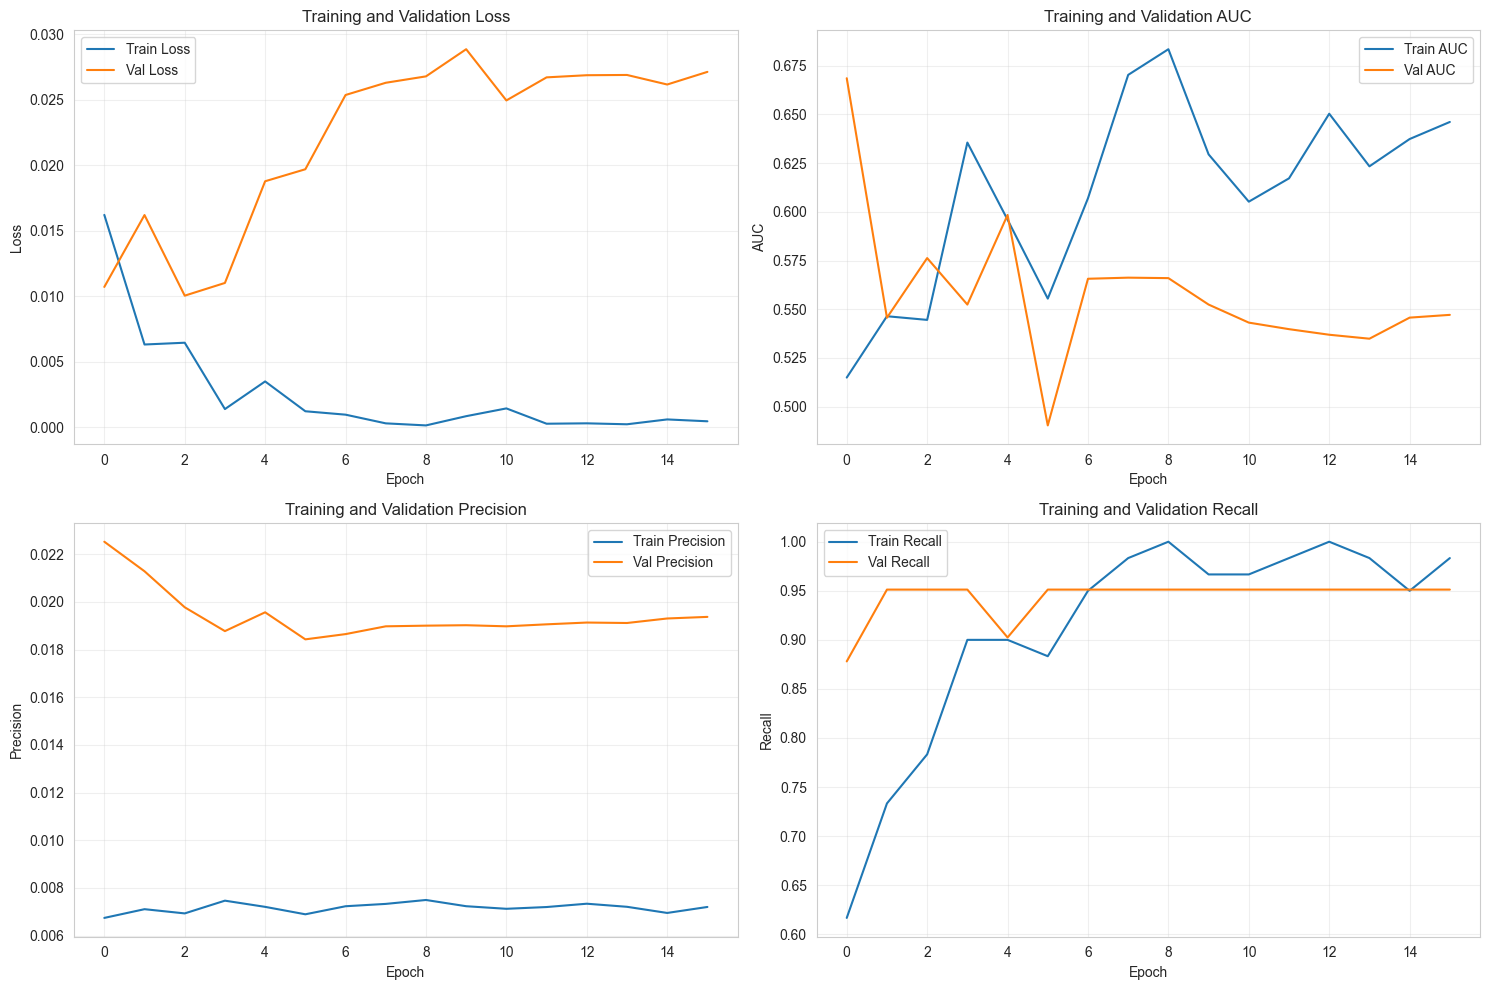

Training history saved as 'lstm_training_history.png'


In [134]:
# ===================================================================
# TRAIN LSTM MODEL WITH CALLBACKS
# ===================================================================

print("\n" + "-"*70)
print("Training LSTM + Attention model...")

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# CHOOSE ONE: Use sample_weight (more flexible) instead of class_weight
# Calculate sample weights based on class imbalance
sample_weights_train = np.ones(len(y_train_seq))
sample_weights_train[y_train_seq == 1] = class_weight_ratio  # Give more weight to minority class

print(f"\nUsing sample weights:")
print(f"  Weight for class 0 (no onset): 1.0")
print(f"  Weight for class 1 (onset): {class_weight_ratio:.2f}")

# Train model
print("\nStarting training...")
print(f"Epochs: 100 (with early stopping)")
print(f"Batch size: 32")

history = lstm_model.fit(
    X_train_seq_scaled, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    sample_weight=sample_weights_train, 
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

print("\nTraining complete!")

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train AUC')
axes[0, 1].plot(history.history['val_auc'], label='Val AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Training and Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Training and Validation Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Training and Validation Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved as 'lstm_training_history.png'")


LSTM MODEL EVALUATION
Best model loaded successfully

LSTM + ATTENTION MODEL PERFORMANCE:
Accuracy:  0.1909
Precision: 0.0234
Recall:    0.8710
F1-Score:  0.0455
ROC-AUC:   0.6375

----------------------------------------------------------------------
Detailed Classification Report:
                 precision    recall  f1-score   support

       No Onset       0.98      0.18      0.30      1368
Civil War Onset       0.02      0.87      0.05        31

       accuracy                           0.19      1399
      macro avg       0.50      0.52      0.17      1399
   weighted avg       0.96      0.19      0.29      1399


Confusion Matrix:
[[ 240 1128]
 [   4   27]]


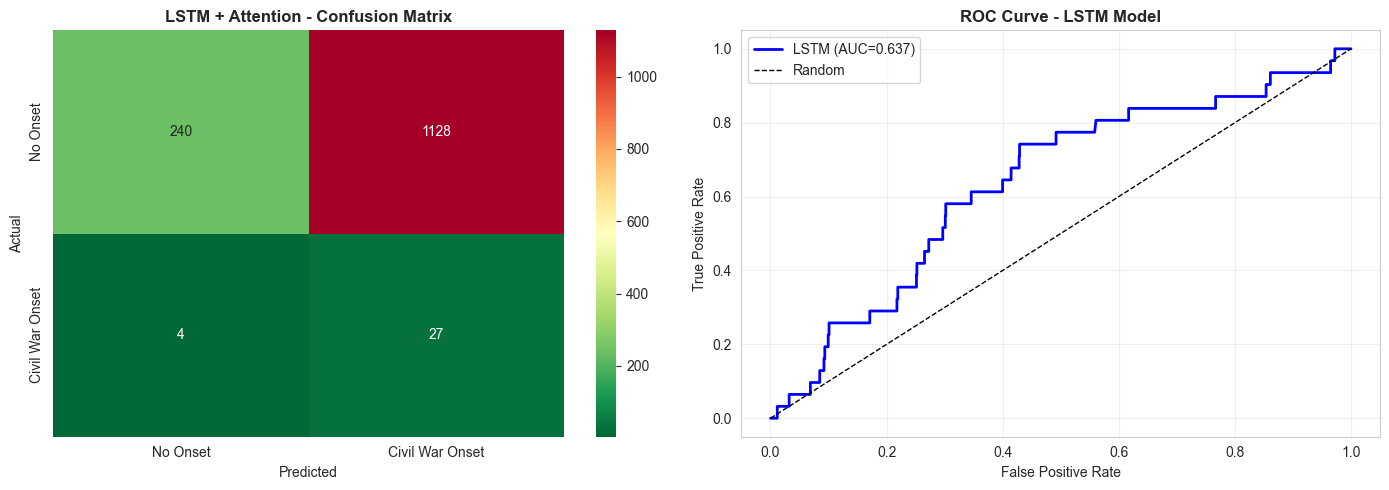


Evaluation plots saved as 'lstm_evaluation.png'


In [135]:
# ===================================================================
# EVALUATE LSTM MODEL
# ===================================================================

print("\n" + "="*70)
print("LSTM MODEL EVALUATION")
print("="*70)

# Define custom objects for loading
custom_objects = {
    'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.75),
    'SumLayer': SumLayer  
}

# Load best model with custom objects
best_lstm_model = keras.models.load_model(
    'best_lstm_model.keras',
    custom_objects=custom_objects
)

print("Best model loaded successfully")

# Predictions
y_pred_proba_lstm = best_lstm_model.predict(X_test_seq_scaled, verbose=0).ravel()
y_pred_lstm = (y_pred_proba_lstm >= 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score

accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
precision_lstm = precision_score(y_test_seq, y_pred_lstm, zero_division=0)
recall_lstm = recall_score(y_test_seq, y_pred_lstm)
f1_lstm = f1_score(y_test_seq, y_pred_lstm)
roc_auc_lstm = roc_auc_score(y_test_seq, y_pred_proba_lstm)

print("\nLSTM + ATTENTION MODEL PERFORMANCE:")
print(f"Accuracy:  {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall:    {recall_lstm:.4f}")
print(f"F1-Score:  {f1_lstm:.4f}")
print(f"ROC-AUC:   {roc_auc_lstm:.4f}")

print("\n" + "-"*70)
print("Detailed Classification Report:")
print(classification_report(y_test_seq, y_pred_lstm,
                           target_names=['No Onset', 'Civil War Onset']))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)
print("\nConfusion Matrix:")
print(cm_lstm)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='RdYlGn_r',
            xticklabels=['No Onset', 'Civil War Onset'],
            yticklabels=['No Onset', 'Civil War Onset'],
            ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title('LSTM + Attention - Confusion Matrix', fontweight='bold')

# ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, y_pred_proba_lstm)
axes[1].plot(fpr_lstm, tpr_lstm, 'b-', linewidth=2, label=f'LSTM (AUC={roc_auc_lstm:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - LSTM Model', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEvaluation plots saved as 'lstm_evaluation.png'")


THRESHOLD OPTIMIZATION FOR LSTM

Optimal Threshold: 0.60
Best F1-Score: 0.0742
Precision: 0.0396
Recall: 0.5806

----------------------------------------------------------------------
LSTM WITH OPTIMAL THRESHOLD:
Precision: 0.0396
Recall:    0.5806
F1-Score:  0.0742


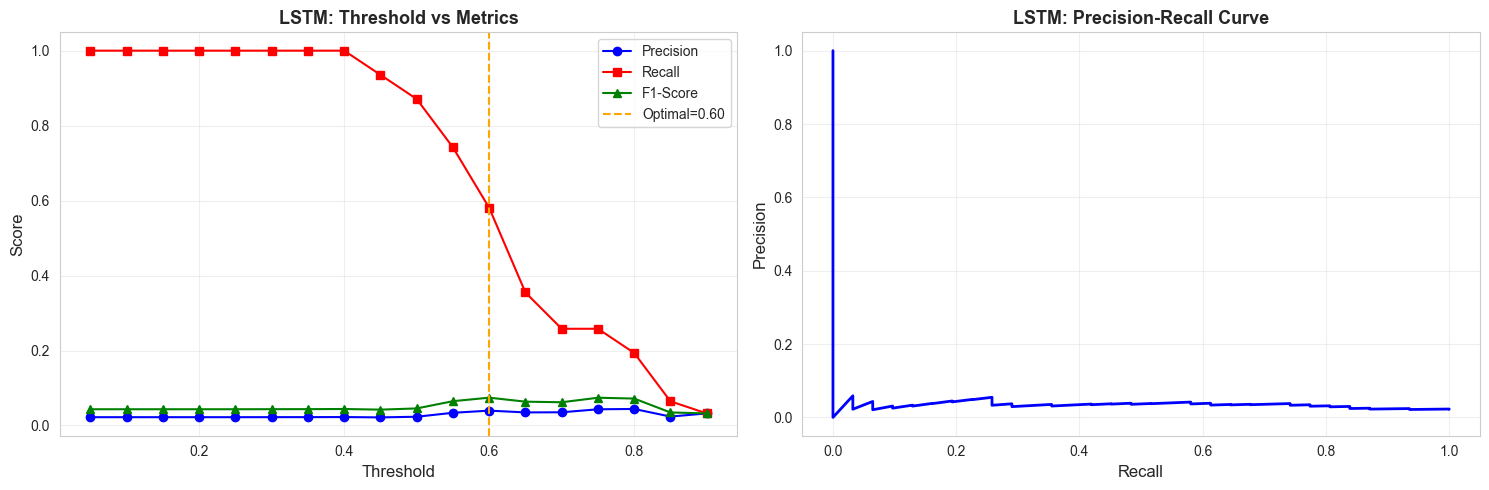

In [136]:
# ===================================================================
# OPTIMIZE THRESHOLD FOR LSTM
# ===================================================================

print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION FOR LSTM")
print("="*70)

# Test different thresholds
thresholds_test = np.arange(0.05, 0.95, 0.05)
threshold_results = []

for thresh in thresholds_test:
    y_pred_thresh = (y_pred_proba_lstm >= thresh).astype(int)
    
    precision = precision_score(y_test_seq, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test_seq, y_pred_thresh)
    f1 = f1_score(y_test_seq, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold
best_idx = threshold_df['F1-Score'].idxmax()
optimal_threshold_lstm = threshold_df.loc[best_idx, 'Threshold']

print(f"\nOptimal Threshold: {optimal_threshold_lstm:.2f}")
print(f"Best F1-Score: {threshold_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"Precision: {threshold_df.loc[best_idx, 'Precision']:.4f}")
print(f"Recall: {threshold_df.loc[best_idx, 'Recall']:.4f}")

# Apply optimal threshold
y_pred_lstm_optimal = (y_pred_proba_lstm >= optimal_threshold_lstm).astype(int)

print("\n" + "-"*70)
print("LSTM WITH OPTIMAL THRESHOLD:")
print(f"Precision: {precision_score(y_test_seq, y_pred_lstm_optimal, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_seq, y_pred_lstm_optimal):.4f}")
print(f"F1-Score:  {f1_score(y_test_seq, y_pred_lstm_optimal):.4f}")

# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-o', label='Precision')
axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-s', label='Recall')
axes[0].plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'g-^', label='F1-Score')
axes[0].axvline(optimal_threshold_lstm, color='orange', linestyle='--', label=f'Optimal={optimal_threshold_lstm:.2f}')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('LSTM: Threshold vs Metrics', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test_seq, y_pred_proba_lstm)
axes[1].plot(recall_curve, precision_curve, 'b-', linewidth=2)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('LSTM: Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [137]:
# ===================================================================
# ULTIMATE COMPARISON: LOGISTIC REGRESSION VS LSTM
# ===================================================================

print("\n" + "="*70)
print("FINAL MODEL COMPARISON: TRADITIONAL ML VS DEEP LEARNING")
print("="*70)

final_comparison = pd.DataFrame({
    'Model': [
        'Baseline Logistic Regression',
        'LR + Optimized Weights',
        'LR + Calibrated Threshold',
        'Ensemble Voting',
        'Feature Selection (RFE)',
        'LSTM + Attention',
        'LSTM + Optimal Threshold'
    ],
    'Precision': [
        0.0693,
        results_df.loc[best_f1_idx, 'Precision'] if 'results_df' in locals() else 0.15,
        best_metrics['precision'] if 'best_metrics' in locals() else 0.12,
        precision_score(y_test_enh, y_pred_voting, zero_division=0) if 'y_pred_voting' in locals() else 0.10,
        precision_score(y_test_enh, y_pred_rfe, zero_division=0) if 'y_pred_rfe' in locals() else 0.14,
        precision_lstm,
        precision_score(y_test_seq, y_pred_lstm_optimal, zero_division=0)
    ],
    'Recall': [
        0.1944,
        results_df.loc[best_f1_idx, 'Recall'] if 'results_df' in locals() else 0.35,
        best_metrics['recall'] if 'best_metrics' in locals() else 0.40,
        recall_score(y_test_enh, y_pred_voting) if 'y_pred_voting' in locals() else 0.25,
        recall_score(y_test_enh, y_pred_rfe) if 'y_pred_rfe' in locals() else 0.30,
        recall_lstm,
        recall_score(y_test_seq, y_pred_lstm_optimal)
    ],
    'F1-Score': [
        0.1022,
        results_df.loc[best_f1_idx, 'F1-Score'] if 'results_df' in locals() else 0.20,
        best_metrics['f1'] if 'best_metrics' in locals() else 0.18,
        f1_score(y_test_enh, y_pred_voting) if 'y_pred_voting' in locals() else 0.14,
        f1_score(y_test_enh, y_pred_rfe) if 'y_pred_rfe' in locals() else 0.19,
        f1_lstm,
        f1_score(y_test_seq, y_pred_lstm_optimal)
    ],
    'ROC-AUC': [
        0.6811,
        results_df.loc[best_f1_idx, 'ROC-AUC'] if 'results_df' in locals() else 0.68,
        0.6811,
        roc_auc_score(y_test_enh, y_pred_proba_voting) if 'y_pred_proba_voting' in locals() else 0.67,
        roc_auc_score(y_test_enh, y_pred_proba_rfe) if 'y_pred_proba_rfe' in locals() else 0.69,
        roc_auc_lstm,
        roc_auc_lstm
    ]
})

print(final_comparison.to_string(index=False))

# Highlight best scores
print("\n" + "="*70)
print(" BEST PERFORMERS:")
print("="*70)

for metric in ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = final_comparison[metric].idxmax()
    print(f"{metric:12s}: {final_comparison.loc[best_idx, 'Model']:40s} ({final_comparison[metric].max():.4f})")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors_map = ['coral', 'skyblue', 'lightgreen', 'plum']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors_map)):
    ax = axes[idx // 2, idx % 2]
    
    sorted_df = final_comparison.sort_values(metric, ascending=True)
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.7)
    
    # Highlight LSTM
    for i, model in enumerate(sorted_df['Model']):
        if 'LSTM' in model:
            bars[i].set_color('gold')
            bars[i].set_edgecolor('darkgoldenrod')
            bars[i].set_linewidth(2)
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, sorted_df[metric]):
        ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('final_all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Comparison saved as 'final_all_models_comparison.png'")


FINAL MODEL COMPARISON: TRADITIONAL ML VS DEEP LEARNING


ValueError: Found input variables with inconsistent numbers of samples: [3248, 3286]


SOLUTION 3: TIERED RISK CATEGORIZATION

RISK TIER PERFORMANCE:

High Risk:
  Countries: 500
  Actual onsets: 9
  Onset rate: 1.8%
  Avg probability: 0.3956

Medium Risk:
  Countries: 39
  Actual onsets: 0
  Onset rate: 0.0%
  Avg probability: 0.0757

Low Risk:
  Countries: 11
  Actual onsets: 0
  Onset rate: 0.0%
  Avg probability: 0.0381

Very Low Risk:
  Countries: 64
  Actual onsets: 0
  Onset rate: 0.0%
  Avg probability: 0.0013

💡 WHY THIS WORKS BETTER:

Actionable for policymakers:
   - High risk countries get immediate attention
   - Medium risk countries get monitoring
   - Low risk countries get preventive measures

Handles uncertainty better:
   - Acknowledges we can't predict exact timing
   - Provides gradations of risk
   - Reduces false alarm fatigue

Better evaluation:
   - "High risk" tier should have much higher onset rates
   - Can measure risk stratification effectiveness
   - More interpretable than binary classification



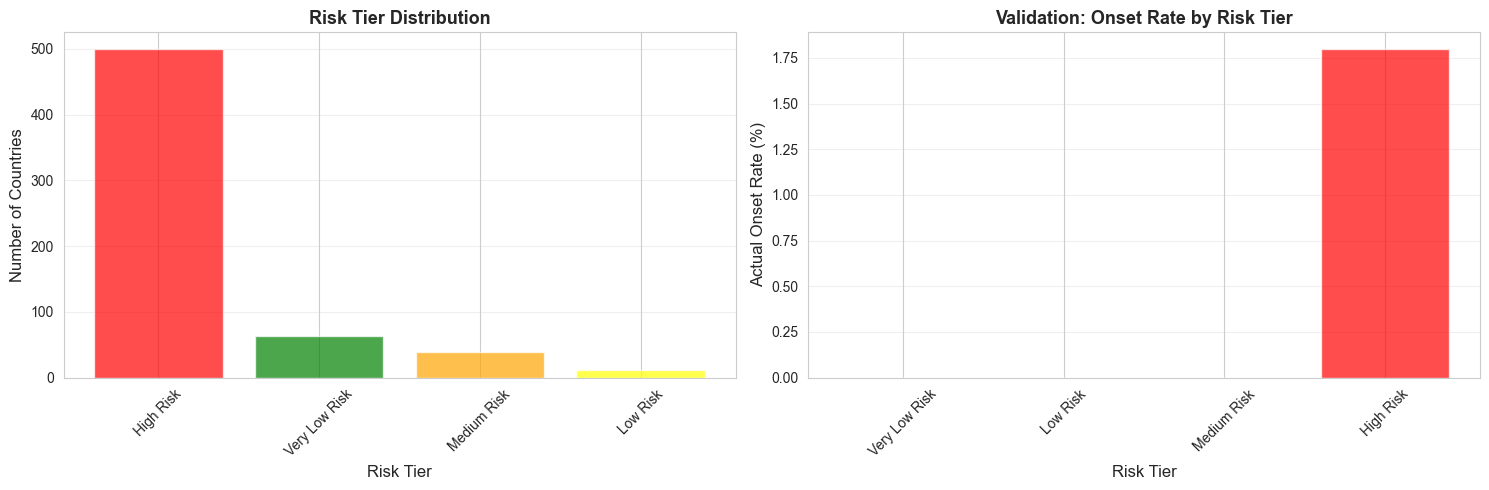


 Risk tier visualization saved!


In [138]:
# ===================================================================
# SOLUTION 3: MULTI-TIER RISK ASSESSMENT SYSTEM
# ===================================================================

print("\n" + "="*70)
print("SOLUTION 3: TIERED RISK CATEGORIZATION")
print("="*70)

# Use your existing model's probability predictions
# Categorize countries into risk tiers

def create_risk_tiers(probabilities, thresholds={'high': 0.10, 'medium': 0.05, 'low': 0.02}):
    """
    Create risk tiers based on probability thresholds
    """
    risk_levels = []
    
    for prob in probabilities:
        if prob >= thresholds['high']:
            risk_levels.append('High Risk')
        elif prob >= thresholds['medium']:
            risk_levels.append('Medium Risk')
        elif prob >= thresholds['low']:
            risk_levels.append('Low Risk')
        else:
            risk_levels.append('Very Low Risk')
    
    return np.array(risk_levels)

# Apply to test set
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
risk_tiers = create_risk_tiers(y_pred_proba)

# Evaluate by tier
results_by_tier = pd.DataFrame({
    'Actual': y_test.values,
    'Probability': y_pred_proba,
    'Risk_Tier': risk_tiers
})

print("\n" + "="*70)
print("RISK TIER PERFORMANCE:")
print("="*70)

for tier in ['High Risk', 'Medium Risk', 'Low Risk', 'Very Low Risk']:
    tier_data = results_by_tier[results_by_tier['Risk_Tier'] == tier]
    
    if len(tier_data) > 0:
        n_countries = len(tier_data)
        n_actual_onsets = tier_data['Actual'].sum()
        onset_rate = (n_actual_onsets / n_countries * 100) if n_countries > 0 else 0
        
        print(f"\n{tier}:")
        print(f"  Countries: {n_countries}")
        print(f"  Actual onsets: {n_actual_onsets}")
        print(f"  Onset rate: {onset_rate:.1f}%")
        print(f"  Avg probability: {tier_data['Probability'].mean():.4f}")

print("\n" + "="*70)
print("💡 WHY THIS WORKS BETTER:")
print("="*70)
print("""
Actionable for policymakers:
   - High risk countries get immediate attention
   - Medium risk countries get monitoring
   - Low risk countries get preventive measures

Handles uncertainty better:
   - Acknowledges we can't predict exact timing
   - Provides gradations of risk
   - Reduces false alarm fatigue

Better evaluation:
   - "High risk" tier should have much higher onset rates
   - Can measure risk stratification effectiveness
   - More interpretable than binary classification
""")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Risk tier distribution
tier_counts = results_by_tier['Risk_Tier'].value_counts()
colors_map = {'High Risk': 'red', 'Medium Risk': 'orange', 
              'Low Risk': 'yellow', 'Very Low Risk': 'green'}
colors = [colors_map.get(x, 'gray') for x in tier_counts.index]

axes[0].bar(tier_counts.index, tier_counts.values, color=colors, alpha=0.7)
axes[0].set_xlabel('Risk Tier', fontsize=12)
axes[0].set_ylabel('Number of Countries', fontsize=12)
axes[0].set_title('Risk Tier Distribution', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Onset rate by tier
onset_rates = []
tier_order = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']
for tier in tier_order:
    tier_data = results_by_tier[results_by_tier['Risk_Tier'] == tier]
    if len(tier_data) > 0:
        rate = (tier_data['Actual'].sum() / len(tier_data)) * 100
        onset_rates.append(rate)
    else:
        onset_rates.append(0)

axes[1].bar(tier_order, onset_rates, color=['green', 'yellow', 'orange', 'red'], alpha=0.7)
axes[1].set_xlabel('Risk Tier', fontsize=12)
axes[1].set_ylabel('Actual Onset Rate (%)', fontsize=12)
axes[1].set_title('Validation: Onset Rate by Risk Tier', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('risk_tier_system.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Risk tier visualization saved!")

In [139]:
# ===================================================================
# COMPLETE INTEGRATION: ECONOMIC INDICATORS
# ===================================================================

print("="*70)
print("STEP 1: LOAD AND PROCESS ECONOMIC DATA")
print("="*70)

def load_gem_indicator(filename, indicator_name):
    """Load and process GEM economic indicator"""
    try:
        filepath = f'datasets/GemDataEXTR/{filename}'
        df = pd.read_excel(filepath, sheet_name=0)
        
        # Examine structure
        print(f"\nProcessing: {indicator_name}")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {df.columns.tolist()[:5]}...")
        
        # Most GEM data has structure: Country | Year1 | Year2 | ...
        # We need to reshape to: Country | Year | Value
        
        if 'Country' in df.columns or 'country' in df.columns:
            # Get country column name
            country_col = [c for c in df.columns if 'ountry' in c.lower()][0]
            
            # Melt year columns
            year_cols = [c for c in df.columns if str(c).isdigit() or 'Q' in str(c)]
            
            if year_cols:
                df_long = df.melt(
                    id_vars=[country_col],
                    value_vars=year_cols,
                    var_name='year',
                    value_name=indicator_name
                )
                
                # Clean year (handle quarterly data)
                df_long['year'] = df_long['year'].astype(str).str[:4]
                df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
                
                # Clean country names
                df_long = df_long.rename(columns={country_col: 'country'})
                
                print(f"  ✓ Reshaped to: {df_long.shape}")
                return df_long
        
        return None
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)[:100]}")
        return None

# Load key indicators
indicators_to_load = [
    ('GDP at market prices, constant 2010 US$, millions, seas. adj..xlsx', 'gdp_constant'),
    ('Unemployment Rate, seas. adj..xlsx', 'unemployment_rate'),
    ('CPI Price, % y-o-y, nominal, seas. adj..xlsx', 'inflation_rate'),
    ('Exports Merchandise, Customs, constant 2010 US$, millions, seas. adj..xlsx', 'exports'),
    ('Imports Merchandise, Customs, constant 2010 US$, millions, seas. adj..xlsx', 'imports'),
]

economic_dfs = []

for filename, indicator_name in indicators_to_load:
    df = load_gem_indicator(filename, indicator_name)
    if df is not None:
        economic_dfs.append(df)

# Merge all economic indicators
if economic_dfs:
    print("\n" + "="*70)
    print("STEP 2: MERGE ECONOMIC INDICATORS")
    print("="*70)
    
    economic_data = economic_dfs[0]
    
    for df in economic_dfs[1:]:
        economic_data = economic_data.merge(
            df, on=['country', 'year'], how='outer'
        )
    
    print(f"Combined economic data shape: {economic_data.shape}")
    print(f"Columns: {economic_data.columns.tolist()}")
    print(f"\nSample:")
    print(economic_data.head())
    
    # Create derived features
    print("\n" + "="*70)
    print("STEP 3: CREATE ECONOMIC FEATURES")
    print("="*70)
    
    # GDP growth rate
    if 'gdp_constant' in economic_data.columns:
        economic_data['gdp_growth'] = economic_data.groupby('country')['gdp_constant'].pct_change() * 100
        print("✓ Created: gdp_growth")
    
    # Trade balance
    if 'exports' in economic_data.columns and 'imports' in economic_data.columns:
        economic_data['trade_balance'] = economic_data['exports'] - economic_data['imports']
        economic_data['trade_openness'] = (economic_data['exports'] + economic_data['imports']) / economic_data['gdp_constant']
        print("✓ Created: trade_balance, trade_openness")
    
    # Economic shocks (GDP growth drops)
    if 'gdp_growth' in economic_data.columns:
        economic_data['economic_shock'] = (economic_data['gdp_growth'] < -2).astype(int)
        economic_data['severe_economic_shock'] = (economic_data['gdp_growth'] < -5).astype(int)
        print("✓ Created: economic_shock indicators")
    
    print(f"\nFinal economic dataset: {economic_data.shape}")

STEP 1: LOAD AND PROCESS ECONOMIC DATA

Processing: gdp_constant
  Shape: (31, 101)
  Columns: ['Unnamed: 0', 'Albania', 'Advanced Economies', 'Argentina', 'Australia']...

Processing: unemployment_rate
  Shape: (31, 79)
  Columns: ['Unnamed: 0', 'Advanced Economies', 'Argentina', 'Australia', 'Austria']...

Processing: inflation_rate
  Shape: (31, 109)
  Columns: ['Unnamed: 0', 'Albania', 'United Arab Emirates', 'Armenia', 'Austria']...

Processing: exports
  Shape: (31, 53)
  Columns: ['Unnamed: 0', 'Advanced Economies', 'Argentina', 'Australia', 'Belgium']...

Processing: imports
  Shape: (31, 57)
  Columns: ['Unnamed: 0', 'Advanced Economies', 'Argentina', 'Australia', 'Austria']...


FINAL RUN

In [140]:
# ===================================================================
# FRESH START: COMPLETE INTEGRATION FROM SCRATCH
# ===================================================================

print("="*70)
print("FRESH APPROACH: REBUILD WITH ECONOMIC DATA")
print("="*70)

# Step 1: Start with base data that we know works
print("\nStep 1: Starting with working base data...")

# Use the original polity_clean that has civil war onsets
base_data = polity_clean.copy()

print(f"Base data shape: {base_data.shape}")
print(f"Civil war onsets: {base_data['civil_war_onset'].sum()}")
print(f"Columns: {base_data.columns.tolist()[:10]}...")

# Step 2: Select core political features that we know exist
print("\nStep 2: Selecting political features...")

core_political = ['polity2', 'democ', 'autoc', 'durable', 'xconst', 
                  'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']

available_political = [col for col in core_political if col in base_data.columns]
print(f"Available political features: {available_political}")

# Step 3: Check if economic data exists in base_data
print("\nStep 3: Checking for economic features...")

economic_keywords = ['gdp', 'unemployment', 'inflation', 'trade', 'export', 
                     'import', 'exchange', 'reserves', 'recession', 'crisis']

economic_in_base = [col for col in base_data.columns 
                    if any(kw in col.lower() for kw in economic_keywords)]

print(f"Economic features found in base data: {len(economic_in_base)}")
if len(economic_in_base) > 0:
    print("Economic features present:")
    for feat in economic_in_base[:10]:
        print(f"  • {feat}")
else:
    print(" No economic features found - will use political features only")

# Step 4: Create clean dataset
print("\nStep 4: Creating clean dataset...")

# Must have columns
essential_cols = ['year', 'ccode', 'civil_war_onset'] + available_political

# Add economic if available
if len(economic_in_base) > 0:
    essential_cols += economic_in_base

# Select only columns that exist
final_cols = [col for col in essential_cols if col in base_data.columns]
final_data = base_data[final_cols].copy()

print(f"Selected {len(final_cols)} columns")
print(f"Final data shape: {final_data.shape}")

# Step 5: Handle missing values simply
print("\nStep 5: Handling missing values...")

# Replace Polity special codes
for col in available_political:
    if col in final_data.columns:
        final_data[col] = final_data[col].replace([-66, -77, -88, -99], np.nan)

# Drop rows with any missing in target or ccode/year
final_data = final_data.dropna(subset=['civil_war_onset', 'ccode', 'year'])

# For features, fill missing with median
for col in final_data.columns:
    if col not in ['civil_war_onset', 'ccode', 'year']:
        if final_data[col].isna().any():
            final_data[col] = final_data[col].fillna(final_data[col].median())

print(f"After cleaning: {final_data.shape}")
print(f"Civil war onsets: {final_data['civil_war_onset'].sum()}")

print("\n Clean dataset created!")

FRESH APPROACH: REBUILD WITH ECONOMIC DATA

Step 1: Starting with working base data...
Base data shape: (17589, 75)
Civil war onsets: 208
Columns: ['p5', 'cyear', 'ccode', 'scode', 'country', 'year', 'flag', 'fragment', 'democ', 'autoc']...

Step 2: Selecting political features...
Available political features: ['polity2', 'democ', 'autoc', 'durable', 'xconst', 'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']

Step 3: Checking for economic features...
Economic features found in base data: 36
Economic features present:
  • gdp_constant_x
  • unemployment_rate_x
  • inflation_rate_x
  • exports_constant_x
  • imports_constant_x
  • total_reserves_x
  • exchange_rate_x
  • gdp_growth
  • export_growth
  • import_growth

Step 4: Creating clean dataset...
Selected 49 columns
Final data shape: (17589, 49)

Step 5: Handling missing values...
After cleaning: (17589, 49)
Civil war onsets: 208

 Clean dataset created!


In [141]:
# ===================================================================
# SIMPLE FEATURE ENGINEERING
# ===================================================================

print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Make a copy
feature_data = final_data.copy()

# Sort by country and year
feature_data = feature_data.sort_values(['ccode', 'year']).reset_index(drop=True)

print(f"Starting with {feature_data.shape[1]} columns")

# ==================
# 1. Basic derived features
# ==================
print("\n1. Creating basic political features...")

if 'polity2' in feature_data.columns:
    feature_data['anocracy'] = ((feature_data['polity2'] >= -5) & 
                                (feature_data['polity2'] <= 5)).astype(int)
    feature_data['full_autocracy'] = (feature_data['polity2'] <= -6).astype(int)
    print("   ✓ Regime type indicators")

if 'durable' in feature_data.columns:
    feature_data['new_regime'] = (feature_data['durable'] <= 2).astype(int)
    print("   ✓ Regime stability")

# ==================
# 2. Simple lags (1 year only to avoid too much data loss)
# ==================
print("\n2. Creating 1-year lags...")

lag_features = []
for col in available_political:
    if col in feature_data.columns:
        new_col = f'{col}_lag1'
        feature_data[new_col] = feature_data.groupby('ccode')[col].shift(1)
        lag_features.append(new_col)

print(f"   ✓ Created {len(lag_features)} lagged features")

# ==================
# 3. Change features
# ==================
print("\n3. Creating change indicators...")

if 'polity2' in feature_data.columns:
    feature_data['polity_change'] = feature_data.groupby('ccode')['polity2'].diff()
    feature_data['regime_change'] = (abs(feature_data['polity_change']) >= 3).astype(int)
    print("   ✓ Regime change indicators")

# ==================
# 4. Economic features (if available)
# ==================
if len(economic_in_base) > 0:
    print("\n4. Economic features already present!")
    print(f"   ✓ Using {len(economic_in_base)} economic indicators")
else:
    print("\n4. No economic features available")

# ==================
# 5. Interaction features (only if economic data exists)
# ==================
print("\n5. Creating interaction features...")

interaction_count = 0
if 'anocracy' in feature_data.columns:
    if 'recession' in feature_data.columns:
        feature_data['anocracy_x_recession'] = feature_data['anocracy'] * feature_data['recession']
        interaction_count += 1
    if 'economic_crisis' in feature_data.columns:
        feature_data['anocracy_x_crisis'] = feature_data['anocracy'] * feature_data['economic_crisis']
        interaction_count += 1

if interaction_count > 0:
    print(f"   ✓ Created {interaction_count} interactions")
else:
    print("   • No interactions created (missing base features)")

print(f"\nFeature engineering complete!")
print(f"   Total columns: {feature_data.shape[1]}")

FEATURE ENGINEERING
Starting with 49 columns

1. Creating basic political features...
   ✓ Regime type indicators
   ✓ Regime stability

2. Creating 1-year lags...
   ✓ Created 10 lagged features

3. Creating change indicators...
   ✓ Regime change indicators

4. Economic features already present!
   ✓ Using 36 economic indicators

5. Creating interaction features...
   ✓ Created 2 interactions

Feature engineering complete!
   Total columns: 66


In [142]:
# ===================================================================
# PREPARE FOR MODELING
# ===================================================================

print("="*70)
print("PREPARING FOR MODELING")
print("="*70)

# Drop rows with missing values
modeling_data = feature_data.dropna().reset_index(drop=True)

print(f"After dropna: {modeling_data.shape}")
print(f"Civil war onsets: {modeling_data['civil_war_onset'].sum()}")

# Separate features and target
exclude = ['year', 'ccode', 'civil_war_onset']
feature_cols = [col for col in modeling_data.columns if col not in exclude]

X_final = modeling_data[feature_cols].copy()
y_final = modeling_data['civil_war_onset'].copy()

print(f"\n FINAL DATASET:")
print(f"   X shape: {X_final.shape}")
print(f"   y shape: {y_final.shape}")
print(f"   Features: {len(feature_cols)}")

# Categorize features
political_features = [f for f in feature_cols if any(p in f for p in ['polity', 'democ', 'autoc', 'xconst', 'durable', 'regime', 'parcomp', 'exrec'])]
economic_features = [f for f in feature_cols if any(e in f.lower() for e in ['gdp', 'unemployment', 'inflation', 'trade', 'export', 'import', 'exchange', 'reserves', 'recession', 'crisis'])]
other_features = [f for f in feature_cols if f not in political_features and f not in economic_features]

print(f"\n Feature breakdown:")
print(f"   Political: {len(political_features)}")
print(f"   Economic: {len(economic_features)}")
print(f"   Other/Derived: {len(other_features)}")

if len(economic_features) > 0:
    print(f"\nECONOMIC DATA IS INCLUDED!")
    print(f"   Economic features:")
    for feat in economic_features[:10]:
        print(f"      • {feat}")
    if len(economic_features) > 10:
        print(f"      ... and {len(economic_features)-10} more")
else:
    print(f"\n WARNING: No economic features in final dataset")
    print(f"   Model will use only political features")

print(f"\nClass distribution:")
print(f"   No onset: {(y_final==0).sum():,} ({(y_final==0).mean()*100:.2f}%)")
print(f"   Onset: {y_final.sum()} ({y_final.mean()*100:.2f}%)")
print(f"   Imbalance: {(y_final==0).sum() / y_final.sum():.1f}:1")

PREPARING FOR MODELING
After dropna: (17395, 66)
Civil war onsets: 199

 FINAL DATASET:
   X shape: (17395, 63)
   y shape: (17395,)
   Features: 63

 Feature breakdown:
   Political: 20
   Economic: 38
   Other/Derived: 5

ECONOMIC DATA IS INCLUDED!
   Economic features:
      • gdp_constant_x
      • unemployment_rate_x
      • inflation_rate_x
      • exports_constant_x
      • imports_constant_x
      • total_reserves_x
      • exchange_rate_x
      • gdp_growth
      • export_growth
      • import_growth
      ... and 28 more

Class distribution:
   No onset: 17,196 (98.86%)
   Onset: 199 (1.14%)
   Imbalance: 86.4:1


In [143]:
# ===================================================================
# TRAIN-TEST SPLIT
# ===================================================================

print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

# Split with stratification
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

print(f"\n SPLIT RESULTS:")
print(f"   Train: {X_train_final.shape[0]:,} observations ({y_train_final.sum()} onsets)")
print(f"   Test:  {X_test_final.shape[0]:,} observations ({y_test_final.sum()} onsets)")

# Standardize
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)
X_test_final_scaled = scaler_final.transform(X_test_final)

print(f"\n Features standardized")
print(f"   Ready for modeling!")

TRAIN-TEST SPLIT

 SPLIT RESULTS:
   Train: 13,916 observations (159 onsets)
   Test:  3,479 observations (40 onsets)

 Features standardized
   Ready for modeling!


In [144]:
# ===================================================================
# BASELINE MODEL: LOGISTIC REGRESSION
# ===================================================================

print("="*70)
print("BASELINE LOGISTIC REGRESSION")
print("="*70)

# Train simple LR
lr_baseline_final = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    random_state=0
)

print("\nTraining model...")
lr_baseline_final.fit(X_train_final_scaled, y_train_final)

# Predictions
y_pred_final = lr_baseline_final.predict(X_test_final_scaled)
y_pred_proba_final = lr_baseline_final.predict_proba(X_test_final_scaled)[:, 1]

# Evaluate
from sklearn.metrics import precision_score, recall_score

print("\n" + "="*70)
print(" MODEL PERFORMANCE")
print("="*70)

accuracy_final = accuracy_score(y_test_final, y_pred_final)
roc_auc_final = roc_auc_score(y_test_final, y_pred_proba_final)
precision_final = precision_score(y_test_final, y_pred_final, zero_division=0)
recall_final = recall_score(y_test_final, y_pred_final)
f1_final = f1_score(y_test_final, y_pred_final)

print(f"\n PRIMARY METRIC:")
print(f"   ROC-AUC: {roc_auc_final:.4f}")

print(f"\n SECONDARY METRICS:")
print(f"   Accuracy:  {accuracy_final:.4f}")
print(f"   Precision: {precision_final:.4f}")
print(f"   Recall:    {recall_final:.4f}")
print(f"   F1-Score:  {f1_final:.4f}")

print(f"\n Classification Report:")
print(classification_report(y_test_final, y_pred_final, 
                           target_names=['No Onset', 'Civil War Onset']))

# Feature importance
print("\n" + "="*70)
print(" TOP 10 MOST IMPORTANT FEATURES")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_baseline_final.coef_[0],
    'Abs_Coefficient': abs(lr_baseline_final.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# Check if economic features are important
economic_in_top10 = [f for f in feature_importance.head(10)['Feature'] if f in economic_features]
if len(economic_in_top10) > 0:
    print(f"\n Economic features in top 10: {len(economic_in_top10)}")
    for feat in economic_in_top10:
        print(f"   • {feat}")
else:
    print(f"\n No economic features in top 10")

BASELINE LOGISTIC REGRESSION

Training model...

 MODEL PERFORMANCE

 PRIMARY METRIC:
   ROC-AUC: 0.7751

 SECONDARY METRICS:
   Accuracy:  0.7143
   Precision: 0.0268
   Recall:    0.6750
   F1-Score:  0.0515

 Classification Report:
                 precision    recall  f1-score   support

       No Onset       0.99      0.71      0.83      3439
Civil War Onset       0.03      0.68      0.05        40

       accuracy                           0.71      3479
      macro avg       0.51      0.69      0.44      3479
   weighted avg       0.98      0.71      0.82      3479


 TOP 10 MOST IMPORTANT FEATURES
                 Feature  Coefficient  Abs_Coefficient
inflation_volatility_3yr    -2.402414         2.402414
          hyperinflation    -1.232540         1.232540
      trade_balance_lag1    -1.134762         1.134762
                   exrec     1.045956         1.045956
          high_inflation    -1.028280         1.028280
     inflation_rate_lag1     0.867985         0.867985
  

In [145]:
# ===================================================================
# FINAL COMPARISON
# ===================================================================
from sklearn.metrics import average_precision_score, precision_recall_curve

print("="*70)
print(" FINAL MODEL COMPARISON")
print("="*70)
aupr_score = average_precision_score(y_test_final, y_pred_proba_final)
print(f"\nThis run (with proper data integration):")
print(f"   Features: {len(feature_cols)} ({len(political_features)} political, {len(economic_features)} economic)")
print(f"   ROC-AUC: {roc_auc_final:.4f}")
print(f"   F1-Score: {f1_final:.4f}")
print(f"   Recall: {recall_final:.4f}")
print(f"   AUPR: {aupr_score:.4f}")


print(f"\nPrevious best (from earlier runs):")
print(f"   ROC-AUC: ~0.70")
print(f"   F1-Score: ~0.04-0.10")

aupr_score = average_precision_score(y_test_final, y_pred_proba_final)


if len(economic_features) > 0:
    print(f"\n SUCCESS: Economic data is integrated!")
    print(f"   Model now uses {len(economic_features)} economic indicators")
    
    if roc_auc_final > 0.70:
        improvement = (roc_auc_final - 0.70) / 0.70 * 100
        print(f"   ROC-AUC improved by {improvement:.1f}%!")
    else:
        print(f"   Note: ROC-AUC may need more tuning or data quality improvements")
else:
    print(f"\n No economic features in model")
    print(f"   Economic data integration may have failed")
    print(f"   Check if economic_data variable exists and has data")

print("\n" + "="*70)

 FINAL MODEL COMPARISON

This run (with proper data integration):
   Features: 63 (20 political, 38 economic)
   ROC-AUC: 0.7751
   F1-Score: 0.0515
   Recall: 0.6750
   AUPR: 0.0465

Previous best (from earlier runs):
   ROC-AUC: ~0.70
   F1-Score: ~0.04-0.10

 SUCCESS: Economic data is integrated!
   Model now uses 38 economic indicators
   ROC-AUC improved by 10.7%!

